# peaks Tutorial 2: Data processing

In [1]:
##### These lines just for debugging purposes #####
%load_ext autoreload
%autoreload 2
%aimport peaks
####################################################

from peaks.core import *

<a id='top'></a>
This notebook gives various examples of standard ARPES data processing operations implemented within `peaks`. Click on the links below to jump to the specific cases:
 - <a href='#BE'>Binding energy and k-space conversions</a>
  - <a href='#disps'>Dispersions</a>
  - <a href='#FS'>Fermi maps</a>
  - <a href='#kz'>kz scans</a>
 - <a href='#batch'>Batch processing</a>
 - <a href='#merge'>Merging</a>
 - <a href='#norm'>Normalisation</a>
 - <a href='#bgs'>Background subtraction</a>
 - <a href='#binning'>Data binning</a>
 - <a href='#Smoothing'>Smoothing</a>
 - <a href='#deriv'>Derivative-type methods</a>
   - <a href='#curv'>Curvature</a>
   - <a href='#min_grad'>Minium gradient method</a>
 - <a href='#symm'>Symmetrisation</a>

<a id='BE'></a>
## Binding energy and k-space conversions  
Convert data to binding energy and k-space dependning on scan and analyser type. The high-level function for any data conversion (KE to BE and/or angle to k) is `peaks.process.process.proc()`.

In [4]:
help(proc)

Help on function proc in module peaks.core.process.process:

proc(data_in, **kwargs)
    Master function for data processing k-space and binding energy conversions. Accepts multiple types of data
    (dispersions, hv-scans, angle maps etc.) and returns data in binding energy, k, or both depending on the args
    specified.  Multiple options exist for selecting data, binning data etc.
    
    Parameters
    ------------
    data_in : xr.DaraArray or list(xr.DataArray)
        The data to be converted or a list of dataArrays for batch processing
    
    **kwargs - optional arguments:
        Conversion options; optional calls to specify which conversions should be performed
         (if not supplied, defaults to BE and k conversion if possible with supplied attributes):
            - convert = 'k'; specify to convert only to k-space, leaving in kinetic energy (assumes data
              already in KE, does not work for kz-scans as KE varies through the scan)
            - convert = 'BE

### Conversion to binding energy
To convert data to binding energy, we need some reference for the Fermi level. The following references are currently accepted:
- fitting parameters generated by a fit to the Fermi energy of e.g. a poly gold sample, in a dictionary form of polynomial coefficients, e.g.:
```
{'c0': 105.07837338559817,
 'c1': 0.00021092006222556432,
 'c2': -6.373415730141268e-05,
 'c3': -2.3182740086084596e-07}
```
 The correct form is automatically output by fitting a reference sample using `PyPhoto.fit.fit_fermi`; 
- an xarray of Fermi level vs. theta_par, with dimension theta_par. The correct form is automatically output by fitting a reference sample using `PyPhoto.fit.fit_fermi`, calling with `output_type='array'`. This should extrapolate if the data to be corrected covers a larger angle range than the original data, but the extrapolation may not be great outside the fit range;
- a float, resulting in a rigid shift of the Fermi level.

E.g. taking a reference poly gold scan:

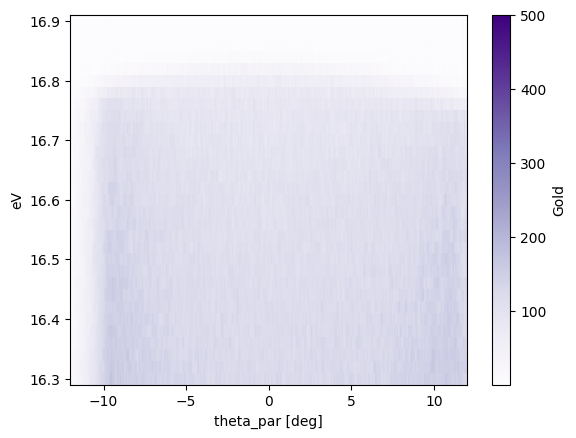

In [5]:
#Load relevant Au correction
file = "example_data/Gold.xy" #StA ARPES Disp.
gold = load_data(file).sel(eV=slice(16.3,None))
gold.plot(vmax=500,y='eV')

In [7]:
estimate_EF(gold, fit=False)

16.8

To extract the relevant E_F correction from this, we can fit using `PyPhoto.process.fermi_level_corrections.fit_fermi`:

In [8]:
help(fit_fermi)

Help on function fit_fermi in module peaks.core.fit.fit_fermi:

fit_fermi(dispersion, **kwargs)
    This function calculates a Fermi level correction for the input dispersion, assuming a fit as follows:
    (DOS*Fermi_function) + Bkg, where DOS and Bkg are linear functions
    
    Input:
        dispersion - the dispersion to be corrected (xarray)
        **kwargs - used to modify the method to calculate the the Fermi level correction:
            EF - user defined Fermi level estimate
            theta_par - user defined theta_par fitting range, supplied as slice(theta0, theta1)
            eV_range - user defined eV fitting range around EF, single value for symmetric range, tuple for
            asymmetric range
            sum_range - user defined EDC integration range over theta_par
            fit_type - change correction fit to quadratic if kwarg['fit_type'] = 'quadratic'
            output_type - change output to be the correction array if kwarg['output_type'] = 'array'
    
  

We can use this to fit a single EDC and return fit parameters (NB if selecting from an array, use keep_attrs=True to retain array attributes):

More useful for dispersion correction is to fit over the dispersion, selecting some range.

EDC fitting progress:   0%|          | 0/342 [00:00<?, ?it/s]

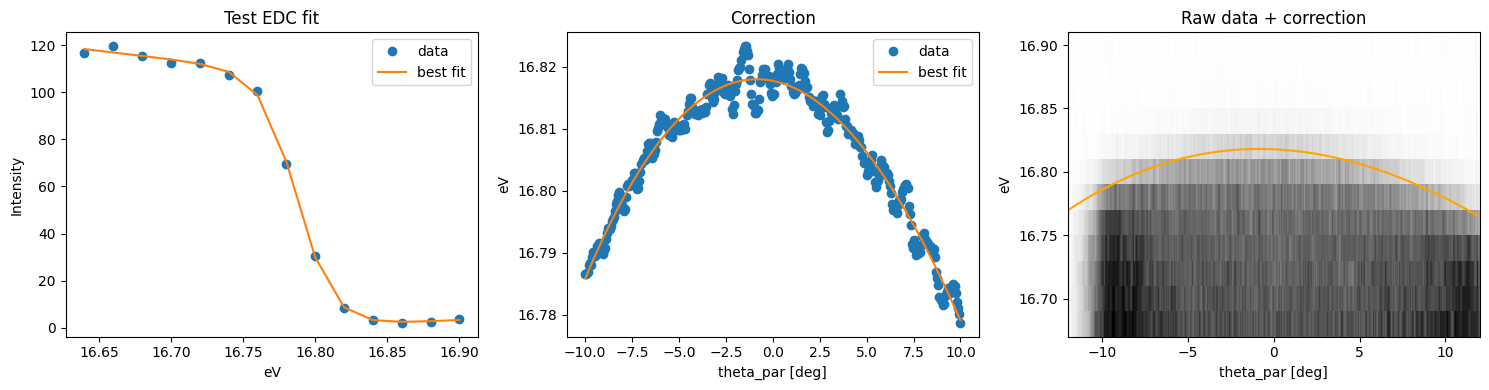

In [9]:
correction = gold.fit_fermi(theta_par=slice(-10,10)) #use reduced theta_par range

We can correct the gold dispersion by its own EF_correction (see below), to check the Fermi edge is straightened up

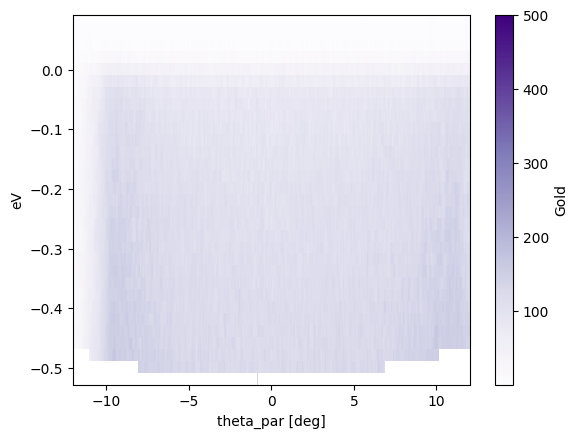

In [11]:
b = gold.proc(convert='BE', EF_correction = correction)
b.plot(vmax=500)

### k-conversion
These functions are all for converting hemispherical-type analysers with an entrance slice, with or without deflectors for virtual scanning of the angular axes. During the conversion, we follow the conventions of Ishida and Shin (https://aip.scitation.org/doi/10.1063/1.5007226) and convert PyPhoto angle conventions into the angle conventions shown below. The following analyser types are currently supported:
- Type I: analyser slit aligned with main rotary axis of manipulator (`ana_slit_angle = 90`), sometimes called 'vertical' slit
- Type II: analyser slit perpendicular to main rotary axis of manipulator (`ana_slit_angle = 0`), sometimes called 'horizontal' slit

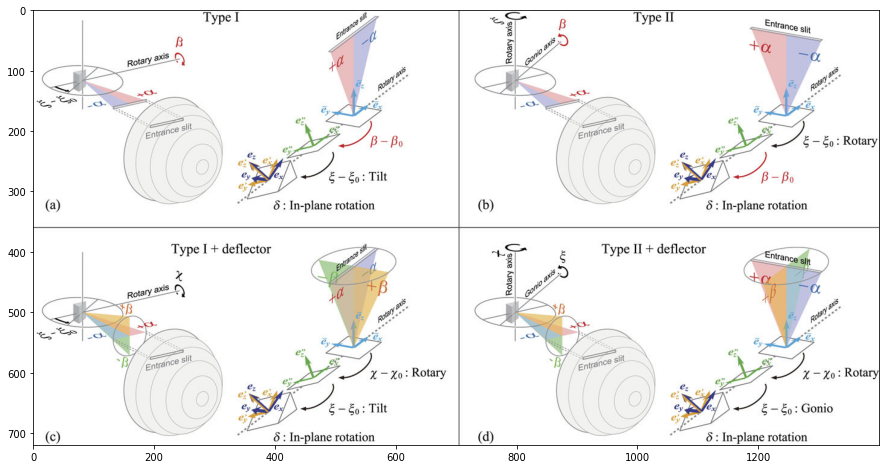

In [13]:
plt.figure(figsize=(16,8))
plt.imshow(plt.imread("../peaks/process/k_conv_angle_conventions.jpeg"))

In the final k-space conversions, we transform form $k_x$ and $k_y$ defined in the sample reference frame to `k_par` (k along entrance slit) and `k_perp` (k perpendicular to entrance slit). In general there are some ambiguities in relative signs of axes, and care should be taken, in particular with merging and with angular offsets, and when multiple angles are stacked on top of each other (e.g. deflector plus manipulator angles).

For a photon energy scan, the out-of-plane momentum $k_\perp$ is always denoted `kz` to disambiguate from our in-plane `k_perp` dimension. Note that in the real crystal, `kz` may not be along the $z$ direction, but whichever axis is out-of-plane.

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='disps'></a>
## Dispersions

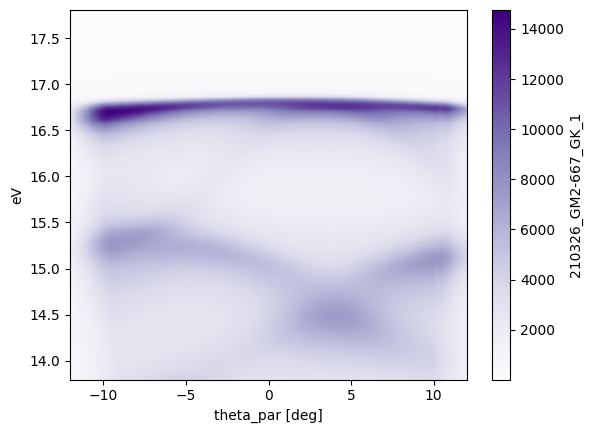

In [12]:
file = "example_data/210326_GM2-667_GK_1.xy" #StA ARPES Disp.
a = load_data(file)
a.plot()

Can use `.align()` as a quick normal emission alignment aid

In [13]:
a.align()

qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=1602.42,711.869 gbl=1602.42,711.869 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1602.42,-711.869 last=-1602.42,-711.869 Δ 1602.42,711.869) : no target window


The quickest way to do the conversion is to call `.proc()` on the data directly. If no relevant attributes are set, it will set all missing relevant angles and normal emissions to zero, and will estiamte the Fermi level from the data. This should not be used for any careful analysis, but can be useful for a quick look.

In [15]:
a.proc().plot()

 Analysis warning: Fermi level set from automatic estimation to 16.811 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.


NameError: name 'k_conv' is not defined

For more accurate corrections, we can write the required attributes to the data file, e.g., `a.attrs['EF_correction'] = correction`, or we can pass them with the call to the `proc` function, which also automatically writes them to the attributes:

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 0.0}


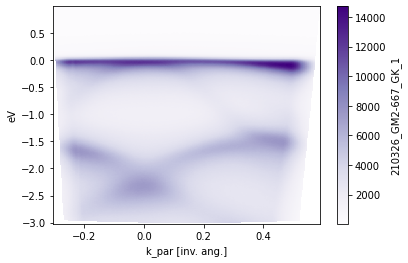

In [11]:
a.proc(EF_correction=correction, polar=0, norm_polar = 3.85).plot()

In [11]:
a

<xarray.DataArray '210326_GM2-667_GK_1' (theta_par: 410, eV: 401)>
array([[ 605.55939 ,  620.25683 ,  633.10641 , ...,   17.6195  ,
          16.435025,   15.327821],
       [ 643.64881 ,  648.66976 ,  667.21025 , ...,   18.287517,
          18.249072,   14.251182],
       [ 682.70142 ,  680.60366 ,  699.6781  , ...,   18.803809,
          21.502145,   15.421237],
       ...,
       [1708.4109  , 1682.793   , 1707.7619  , ...,   18.110158,
          16.634791,   17.655575],
       [1646.4282  , 1647.8145  , 1671.5718  , ...,   15.223157,
          16.308847,   19.634447],
       [1584.1739  , 1598.4336  , 1613.5661  , ...,   13.499489,
          15.367467,   20.573071]])
Coordinates:
  * theta_par  (theta_par) float64 -11.98 -11.92 -11.87 ... 11.87 11.92 11.98
  * eV         (eV) float64 13.8 13.81 13.82 13.83 ... 17.77 17.78 17.79 17.8
Attributes: (12/27)
    scan_name:           210326_GM2-667_GK_1
    scan_type:           dispersion
    sample_description:  None
    eV_type:             kinetic
    beamline:            St Andrews - Phoibos
    analysis_history:    ['EF_correction attribute set from automatic estimat...
    ...                  ...
    azi:                 None
    norm_polar:          3.85
    norm_tilt:           None
    norm_azi:            None
    temp_sample:         None
    temp_cryo:           None

We can specify a desired k-point grid via `dk=float` (Note we now do not need to include the `EF_correction` and `norm_polar` as these have already been written to the attributes):

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 0.0}
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 0.0}


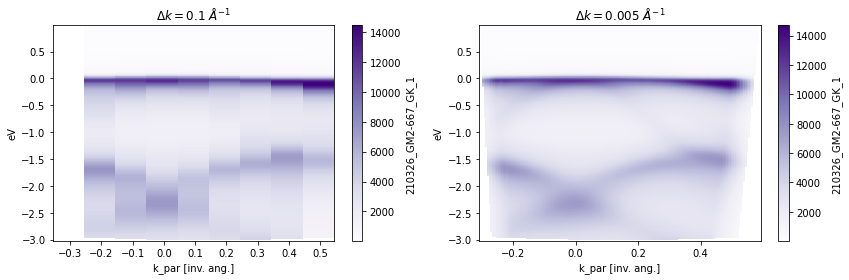

In [18]:
b = a.proc(dk=0.1)
c = a.proc(dk=0.005)

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
b.plot(ax=axes[0])
axes[0].set_title("$\Delta{}k=0.1\;\AA^{-1}$")
c.plot(ax=axes[1])
axes[1].set_title(r"$\Delta{}k=0.005\;\AA^{-1}$")
plt.tight_layout()

We can apply binning in energy and angle as part of the conversion. This can be done with the flag `binning={}` where the dictionary includes the axes to bin over and their factor, e.g. `binning={'eV': 2, 'theta_par': 3}` or the shortcut `bin_factor=n` to apply an $n$ by $n$ binning in eV and theta_par axes. 

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 0.0}


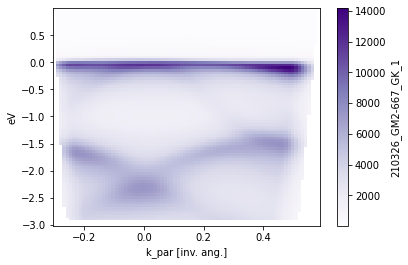

In [19]:
a.proc(bin_factor=5).plot()

We can also pass a `convert` argument to say that we <i>only</i> want to convert to BE, leaving in angle, or to $k$, leaving in KE.

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 0.0}


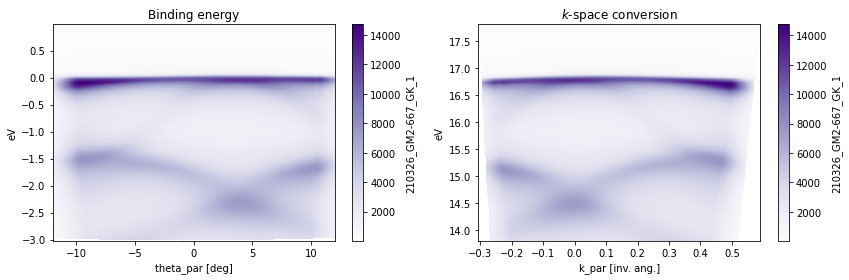

In [21]:
b = a.proc(convert='BE')  # Convert to binding energy, but leave in angle
c = a.proc(convert='k')  # Do k-space conversion, but leave in KE

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
b.plot(ax=axes[0])
axes[0].set_title("Binding energy")
c.plot(ax=axes[1])
axes[1].set_title("$k$-space conversion")
plt.tight_layout()

Even after conversion, you can ask to view against theta_par by passing the relevant flags in plot:

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 0.0}


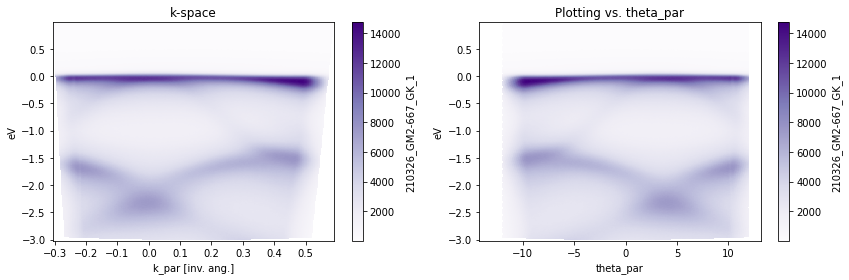

In [12]:
b = a.proc()

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
b.plot(ax=axes[0])
axes[0].set_title("k-space")
b.plot(ax=axes[1], x='theta_par', y='eV')
axes[1].set_title("Plotting vs. theta_par")
plt.tight_layout()


<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='FS'></a>
## Fermi surfaces

Fermi surface corrections work in the same wave for dispersions, but now with the additional arguments:
- `FS=dE` or `FS=(dE,E0)` to return a single Fermi surface of integration width `dE` centered at energy `E0` (defaults to 0)
- `eV=E0` or `eV=slice(E0,E1)` to return a constant energy slice (single value at `E0` or range between `E0` and `E1`)

EDC fitting progress:   0%|          | 0/522 [00:00<?, ?it/s]

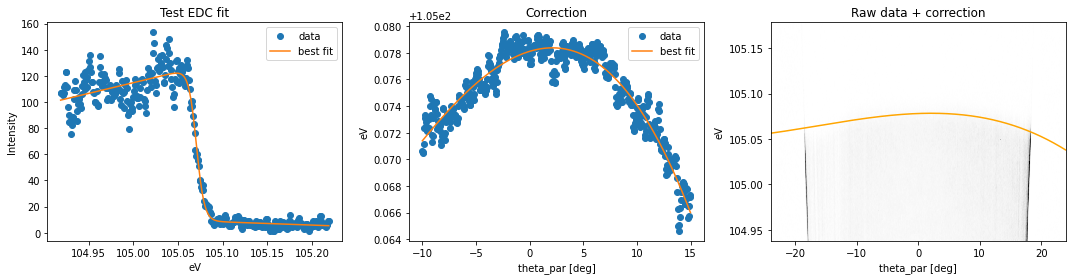

In [14]:
#Load relevant Au correction
file = "example_data/i05-59853.nxs" #Diamond Au measurement
gold = load_data(file)
correction = gold.fit_fermi(theta_par=slice(-10,15), eV_range = (-0.05,0.1), sum_range=0.1)

In [15]:
# Load data (FS map)
file = "example_data/i05-59818.nxs"
a = load_data(file)

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

Quickest version of k-space conversion by supplying no arguments, again simply taking the estimated Fermi level

 Analysis warning: Fermi level set from automatic estimation to 105.066 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_tilt': 0.0, 'norm_azi': -12.5}


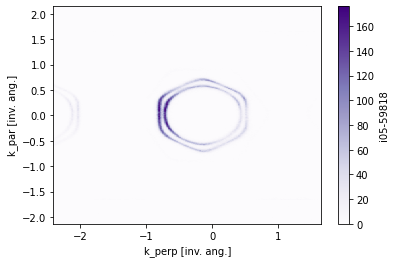

In [31]:
a.proc(FS=0.01).plot()

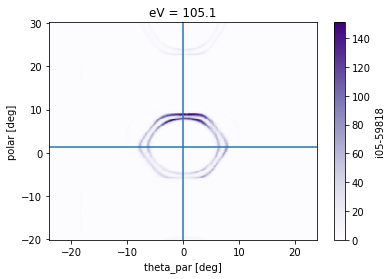

In [34]:
# Plot FS in angle space and estimate normal emission angles
a.FS(105.066, 0.02).plot()
plt.axvline(0)
plt.axhline(1.4)

 Analysis warning: Data array is large, 2x2 binning on energy and theta_par axis has been automatically applied. To run without binning, call function with bin_factor=1.


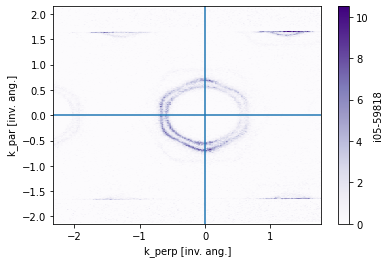

In [35]:
# Call the conversion with normal emissions and EF_correction, also writing them to the attributes of a
b = a.proc(FS=0.01, norm_polar = 1.4, norm_tilt = 0, norm_azi = a.attrs['azi'] + 0.3, EF_correction = correction)
b.plot()
plt.axvline(0)
plt.axhline(0)

Note, we need to be careful with azi offset, as often there is a finite azi values, `a.attrs['azi']`, and typically we want a 'normal' value as some rotation away from this, as in the above: `norm_azi = a.attrs['azi']+0.3`

We can return a dataarray over a finite energy slice by calling with the eV=slice(E0,E1) argument.

In [36]:
%time b = a.proc(eV=slice(-0.1,0))

 Analysis warning: Data array is large, 2x2 binning on energy and theta_par axis has been automatically applied. To run without binning, call function with bin_factor=1.


CPU times: user 1.01 s, sys: 104 ms, total: 1.11 s
Wall time: 1.11 s


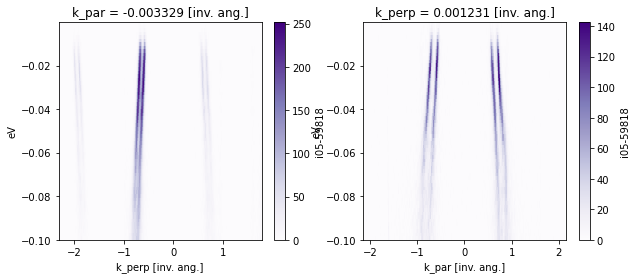

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
b.sel(k_par=0,method='nearest').plot(y='eV', ax=axes[0])
b.sel(k_perp=0,method='nearest').plot(y='eV', ax=axes[1])

In the above, the number of data points needing to be k-space converted in the array exceeded $10^8$ and so an automatic 2x2 binning in energy and theta_par was applied; this is particularly useful for very large arrays, where the conversion time scales badly with the number of data points. To force it to run without this auto-binning, call with the argument `bin_factor=1`. Specific binning can be specified using `bin_factor=n` for $n\times{n}$ binning or `binning={'dim1': n, 'dim2': m, ...}` for $n$-times binning of `dim1`, $m$-times binning of `dim2`, etc., where `dim1` and `dim2` are specific dimensions, e.g. `eV` and `theta_par`.


CPU times: user 20.4 s, sys: 10.4 s, total: 30.8 s
Wall time: 26.2 s


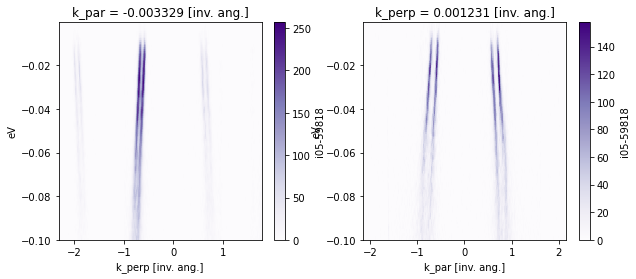

In [42]:
%%time
# Run with binning off - this will take a bit longer now
b = a.proc(eV=slice(-0.1,0), bin_factor=1)
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
b.sel(k_par=0, method='nearest').plot(y='eV', ax=axes[0])
b.sel(k_perp=0, method='nearest').plot(y='eV', ax=axes[1])

We can manually set the k-point spacing (now in both $k_x$ and $k_y$ directions) by `dk=float` (1/AA); the default is 0.01 inv Angs

 Analysis warning: Data array is large, 2x2 binning on energy and theta_par axis has been automatically applied. To run without binning, call function with bin_factor=1.


CPU times: user 1.15 s, sys: 222 ms, total: 1.37 s
Wall time: 575 ms


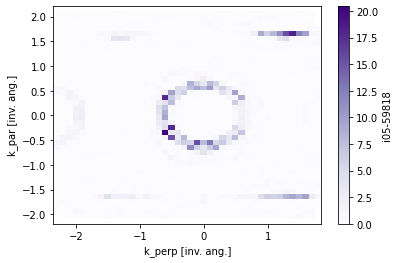

In [48]:
%%time
b = a.proc(dk=0.1, FS=0.02)
b.plot()

 Analysis warning: Data array is large, 2x2 binning on energy and theta_par axis has been automatically applied. To run without binning, call function with bin_factor=1.


CPU times: user 6.13 s, sys: 1.22 s, total: 7.36 s
Wall time: 6.59 s


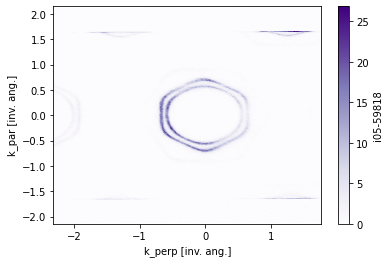

In [49]:
%%time
b = a.proc(dk=0.004, FS=0.02)
b.plot()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='kz'></a>
## Photon energy scans

### Loading hv-dep data/data format
In an hv scan, the most natural representation of the data is as a 3d cube of (hv,theta_par,eV), however the eV axis in raw KE changes as a function of photon energy, adding some extra complexity for the xarray format.

In PyPhoto, the convention is to load (or assemble) a hv-dependent dataset into such a cube, where the eV coordinate (when in kinetic energy mode) is that of the first scan, while a second non-dimension coordinate is included which shows the relevant offset of the KE scale as a function of hv. A warning on load indicates this. 

In [16]:
# Load data (kz map)
a = load_data('example_data/i05-69294.nxs')

<div class="alert alert-block alert-info"><b>Analysis info: </b> Note: single xarray dataarray returned. The kinetic energy coordinate is that of the first scan; corresponding offsets for successive scans are included in the KE_delta coordinate. Run .disp_from_hv(hv) where hv is the relevant photon energy to extract a dispersion with the proper KE scaling for that photon energy. </div>

Persisting data to memory:   0%|          | 0/6 [00:00<?, ?it/s]

In [86]:
a

<xarray.DataArray 'i05-69294' (hv: 61, eV: 1040, theta_par: 1000)>
dask.array<transpose, shape=(61, 1040, 1000), dtype=float32, chunksize=(32, 1040, 1000), chunktype=numpy.ndarray>
Coordinates:
  * hv         (hv) float64 60.0 61.0 62.0 63.0 64.0 ... 117.0 118.0 119.0 120.0
  * theta_par  (theta_par) float64 -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
  * eV         (eV) float64 113.7 113.7 113.7 113.7 ... 115.3 115.3 115.3 115.3
    KE_delta   (hv) float64 -59.76 -58.76 -57.77 -56.77 ... -1.992 -0.996 0.0
Attributes:
    scan_name:           i05-69294
    scan_type:           hv scan
    sample_description:  None
    eV_type:             kinetic
    beamline:            Diamond I05-HR
    analysis_history:    []
    EF_correction:       None
    PE:                  20.0
    hv:                  120.0:60.0 (-1.0)
    pol:                 LH
    sweeps:              None
    dwell:               5.0
    ana_mode:            Ang30
    ana_slit:            0.2s (#500)
    ana_slit_angle:      90
    exit_slit:           10.0
    defl_par:            None
    defl_perp:           None
    x1:                  1.86
    x2:                  -3.162
    x3:                  -0.319
    polar:               0.0
    tilt:                5.0
    azi:                 20.0
    norm_polar:          None
    norm_tilt:           None
    norm_azi:            None
    temp_sample:         20.5
    temp_cryo:           20.0
    scan_command:        scan energy 120 60 -1 centre_energy 114.5 -0.996 ana...

Note, if just plotting an individual dispersion from this by pulling a single slice out of the cube, the KE_delta is shown at the top of the plot, while the eV scale is now incorrect by this value. To correct for this, the helper function `.display.disp_from_hv.disp_from_hv` returns the relevant dispersion at (or closest to) the supplied hv:

In [87]:
help(disp_from_hv)

Help on function disp_from_hv in module peaks.display.disp_from_hv:

disp_from_hv(data, hv, correct_EF_curve=False)
    Return a single dispersion from a hv cube <br>
    Corrects for KE offsets that arise due to the way hv-dep data is stored
    
    Parameters
    ------------
    data : xr.DataArray
         hv-dep cube of data
    
    hv : float
        Photon energy to extract
    
    correct_EF_curve : bool, optional
        Correct for the curvature of the Fermi level <br>
        Based on the supplied normalisation wave in .attrs['EF_correction'] <br>
        Does not convert to BE <br>
        Defaults to False
    
    Returns
    ------------
    data_out : xr.DataArray
        Single dispersion at photon energy closest to requested one



The function `.display.disp_from_hv.hv_plot` further returns the plot of this directly, rather than the xarray dispersion.

In [88]:
help(plot_hv)

Help on function plot_hv in module peaks.display.disp_from_hv:

plot_hv(data, hv, correct_EF_curve=False, **kwargs)
    Return a plot of a single dispersion from a hv cube <br>
    Corrects for KE offsets that arise due to the way hv-dep data is stored
    
    Parameters
    ------------
    data : xr.DataArray
         hv-dep cube of data
    
    hv : float
        Photon energy to extract
    
    correct_EF_curve : bool, optional
        Correct for the curvature of the Fermi level <br>
        Based on the supplied normalisation wave in .attrs['EF_correction'] <br>
        Does not convert to BE <br>
        Defaults to False
    
    **kwargs : optional
        Standard matplotlib calls to pass to plot
    
    Returns
    ------------
    plot
        Desired plot



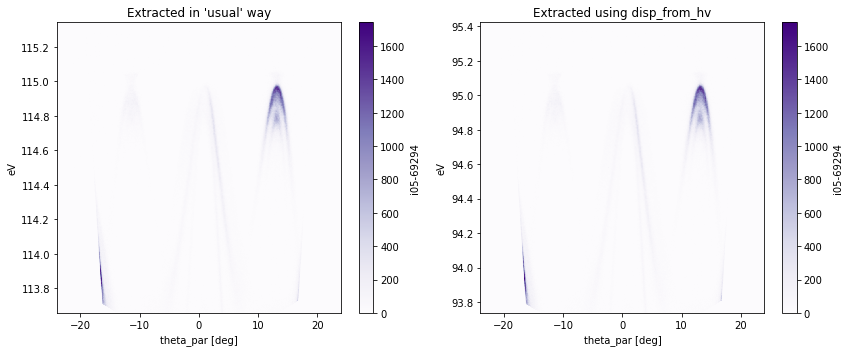

In [89]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
a.sel(hv=100, method='nearest').plot(ax=axes[0])
axes[0].set_title('Extracted in \'usual\' way')
a.plot_hv(100, ax=axes[1])
axes[1].set_title('Extracted using disp_from_hv')
plt.tight_layout()

If an E_F correction attribute exists, you can pass with the argument `correct_EF_curve=True` to also correct the curvature of the Fermi edge

EDC fitting progress:   0%|          | 0/626 [00:00<?, ?it/s]

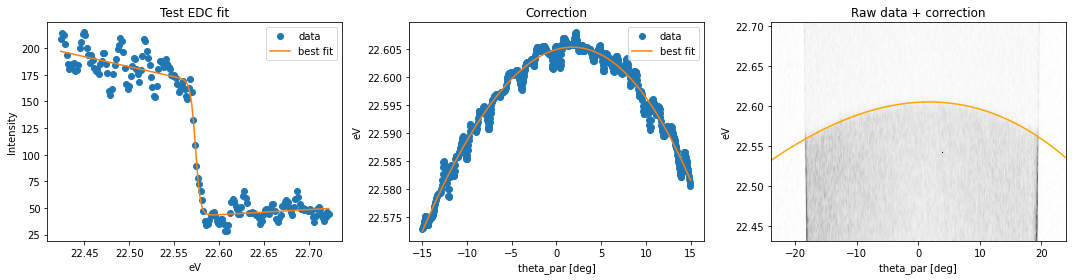

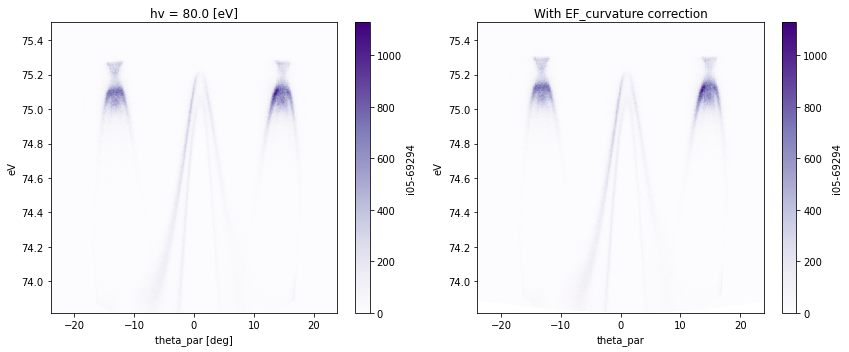

In [93]:
# Load and fit relevant gold scan
fname_Au = 'example_data/i05-70214.nxs'
gold = load_data(fname_Au)
correction = gold.fit_fermi(theta_par=slice(-15,15)) #need to use reduced theta_par range
a.attrs['EF_correction'] = correction #Write this into the attributes

# Plot with and without correction
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
a.plot_hv(80, ax=axes[0])
axes[1].set_title('No EF_curvature correction')
a.plot_hv(80, correct_EF_curve=True, ax=axes[1])
axes[1].set_title('With EF_curvature correction')
plt.tight_layout()

### Auto / guided EF alignment 

In general, the hv scaling at a synchrotron is typically a little off, so as the nominal hv changes by 1 eV, the actual hv (and thus e.g. E_F) changes by a slightly different ammount. It is therefore necessary to apply some correction to the KE positions to get the real features 'flat' as a function of hv. There is a helper function, `.process.fermi_level_corrections.hv_align`, to perform a rough estimate of the Fermi level positions with photon energy.

In [94]:
help(hv_align)

Help on function hv_align in module peaks.process.fermi_level_corrections:

hv_align(data_in, hv_from=0, hv_to=0, hv_step=5, fit_polyorder=3, **kwargs)
    This function performs an automatic alignment of the data from an hv-dep cube trying to do a rough
    alignment of EF
    
    Input:
        data - hv-dep cube of data (xarray)
    
        Optional arguments for specifying fit:
            - hv_from (optional, defaults to first photon energy) - value of photon energy to start the alignment
              from (float)
            - hv_to (optional, defaults to last photon energy) - value of photon energy to perform alignment to
              (float)
            - hv_step (optional, default 5eV) - step size of how many photon energies to correct
            - fit_polyorder (optional, default=3) - set the order of the polynomial function used to fit the Fermi
              level data
    
        **kwargs (further optional arguments):
            Setting EF_correction method:
       

If there is no EF_correction attribute set, this only corrects for $E_F$ shifts effectively averaged across the detector, not for curvature of the Fermi level. The resulting hv-dependent $E_F$ shifts are added as a non-dimension coordinate in the dataarray.

Estimating EF:   0%|          | 0/13 [00:00<?, ?it/s]

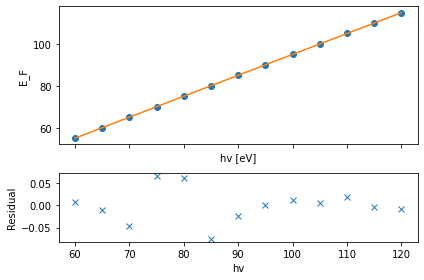

 Analysis warning: Performed automatic Fermi level alignment based on derivative method to find Fermi edge. Check carefully - a more accurate method may be required for proper analysis.


In [104]:
a.attrs['EF_correction'] = None
b = a.hv_align(fit=True)

In [105]:
b

<xarray.DataArray 'i05-69294' (hv: 61, eV: 1040, theta_par: 1000)>
dask.array<transpose, shape=(61, 1040, 1000), dtype=float32, chunksize=(32, 1040, 1000), chunktype=numpy.ndarray>
Coordinates:
  * hv         (hv) float64 60.0 61.0 62.0 63.0 64.0 ... 117.0 118.0 119.0 120.0
  * theta_par  (theta_par) float64 -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
  * eV         (eV) float64 113.7 113.7 113.7 113.7 ... 115.3 115.3 115.3 115.3
    KE_delta   (hv) float64 -59.76 -58.76 -57.77 -56.77 ... -1.992 -0.996 0.0
    EF         (hv) float64 55.32 56.31 57.31 58.31 ... 111.9 112.8 113.8 114.8
Attributes:
    scan_name:           i05-69294
    scan_type:           hv scan
    sample_description:  None
    eV_type:             kinetic
    beamline:            Diamond I05-HR
    analysis_history:    ['Performed automatic Fermi level alignment based on...
    EF_correction:       None
    PE:                  20.0
    hv:                  120.0:60.0 (-1.0)
    pol:                 LH
    sweeps:              None
    dwell:               5.0
    ana_mode:            Ang30
    ana_slit:            0.2s (#500)
    ana_slit_angle:      90
    exit_slit:           10.0
    defl_par:            None
    defl_perp:           None
    x1:                  1.86
    x2:                  -3.162
    x3:                  -0.319
    polar:               0.0
    tilt:                5.0
    azi:                 20.0
    norm_polar:          None
    norm_tilt:           None
    norm_azi:            None
    temp_sample:         20.5
    temp_cryo:           20.0
    scan_command:        scan energy 120 60 -1 centre_energy 114.5 -0.996 ana...

If called with `fit=True` as in the above, this is performed fitting the Fermi level for each photon energy attempted, although in reality this does not perform that well (note the relatively large residuals in the above). The default, or if called with `fit=False`, is to estimate $E_F$ simply from the (negative) peak of the first derivative. This is not necessarily that accurate, but for the right data, works quite well. This is designed mainly for on the fly analysis - for a careful analysis, the user should carefully check the Fermi level alignments.

Estimating EF:   0%|          | 0/13 [00:00<?, ?it/s]

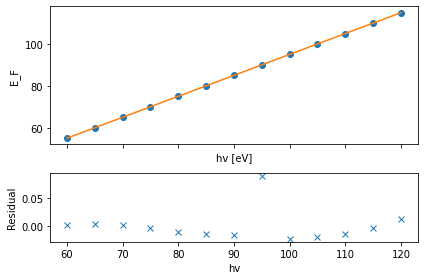

 Analysis warning: Performed automatic Fermi level alignment based on derivative method to find Fermi edge. Check carefully - a more accurate method may be required for proper analysis.


In [106]:
b = a.hv_align()

In [107]:
b

<xarray.DataArray 'i05-69294' (hv: 61, eV: 1040, theta_par: 1000)>
dask.array<transpose, shape=(61, 1040, 1000), dtype=float32, chunksize=(32, 1040, 1000), chunktype=numpy.ndarray>
Coordinates:
  * hv         (hv) float64 60.0 61.0 62.0 63.0 64.0 ... 117.0 118.0 119.0 120.0
  * theta_par  (theta_par) float64 -23.94 -23.9 -23.85 ... 23.85 23.9 23.94
  * eV         (eV) float64 113.7 113.7 113.7 113.7 ... 115.3 115.3 115.3 115.3
    KE_delta   (hv) float64 -59.76 -58.76 -57.77 -56.77 ... -1.992 -0.996 0.0
    EF         (hv) float64 55.4 56.39 57.39 58.38 ... 112.0 113.0 114.0 115.0
Attributes:
    scan_name:           i05-69294
    scan_type:           hv scan
    sample_description:  None
    eV_type:             kinetic
    beamline:            Diamond I05-HR
    analysis_history:    ['Performed automatic Fermi level alignment based on...
    EF_correction:       None
    PE:                  20.0
    hv:                  120.0:60.0 (-1.0)
    pol:                 LH
    sweeps:              None
    dwell:               5.0
    ana_mode:            Ang30
    ana_slit:            0.2s (#500)
    ana_slit_angle:      90
    exit_slit:           10.0
    defl_par:            None
    defl_perp:           None
    x1:                  1.86
    x2:                  -3.162
    x3:                  -0.319
    polar:               0.0
    tilt:                5.0
    azi:                 20.0
    norm_polar:          None
    norm_tilt:           None
    norm_azi:            None
    temp_sample:         20.5
    temp_cryo:           20.0
    scan_command:        scan energy 120 60 -1 centre_energy 114.5 -0.996 ana...

To also correct for the slit curvature, you can add an `EF_correction` manually in the attributes, `a.attrs['EF_correction]'=correction`, or can pass it using the argument `EF_correction=correction` with the `hv_align` function.

Estimating EF:   0%|          | 0/13 [00:00<?, ?it/s]

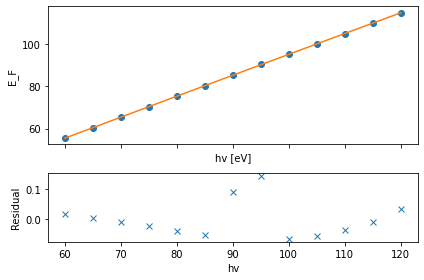

 Analysis warning: Performed automatic Fermi level alignment based on derivative method to find Fermi edge. Check carefully - a more accurate method may be required for proper analysis.


In [108]:
b = a.hv_align(EF_correction=correction)

### kz-conversion
As discussed above, the convention is that `kz` is always the nomenclature for the out-of-plane momentum, $k_\perp$ whether this is $k_z$ or another azis. $k$-space conversion of the data cube is performed with `.process.k_conversion.kz_conv` but is automatically called from `.process.k_conversion.proc` when a cube of data is passed with a dimension `hv`. If no hv-dependent `EF` coordinate has already been added, this will first be run automatically as part of the function call. 

In [110]:
# Load data (kz map)
a = load_data('example_data/i05-69294.nxs')

<div class="alert alert-block alert-info"><b>Analysis info: </b> Note: single xarray dataarray returned. The kinetic energy coordinate is that of the first scan; corresponding offsets for successive scans are included in the KE_delta coordinate. Run .disp_from_hv(hv) where hv is the relevant photon energy to extract a dispersion with the proper KE scaling for that photon energy. </div>

Persisting data to memory:   0%|          | 0/6 [00:00<?, ?it/s]

Estimating EF:   0%|          | 0/13 [00:00<?, ?it/s]

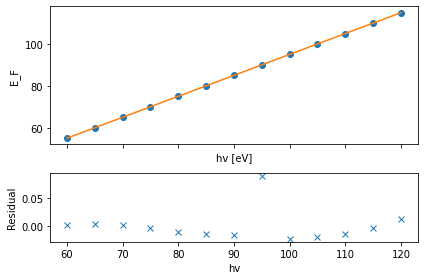

 Analysis warning: Performed automatic Fermi level alignment based on derivative method to find Fermi edge. Check carefully - a more accurate method may be required for proper analysis.
 Analysis warning: No inner potential specified. Default value of 12 eV used. To use specific value call with argument V0=float.
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


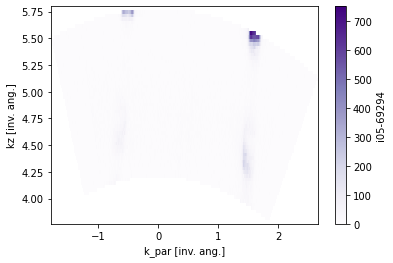

In [112]:
a.proc(FS=0.01).plot()

Estimate normal emisssion.

In [113]:
a.disp_from_hv(80).align()

qt.pointer.dispatch: delivering touch release to same window QWindow(0x0) not QWidgetWindow(0x7fef4fce27e0, name="Aligndisp_panelWindow")
qt.pointer.dispatch: skipping QEventPoint(id=0 ts=0 pos=0,0 scn=1302.65,588.57 gbl=1302.65,588.57 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1302.65,-588.57 last=-1302.65,-588.57 Δ 1302.65,588.57) : no target window
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=1273.49,610.171 gbl=1273.49,610.171 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1273.49,-610.171 last=-1273.49,-610.171 Δ 1273.49,610.171) : no target window
qt.pointer.dispatch: delivering touch release to same window QWindow(0x0) not QWidgetWindow(0x7fef4fce27e0, name="Aligndisp_panelWindow")
qt.pointer.dispatch: skipping QEventPoint(id=1 ts=0 pos=0,0 scn=1267.96,574.064 gbl=1267.96,574.064 Released ellipse=(1x1 ∡ 0) vel=0,0 press=-1267.96,-574.064 last=-1267.96,-574.064 Δ 1267.96,574.064) : no target window


Normal emission: 6.05


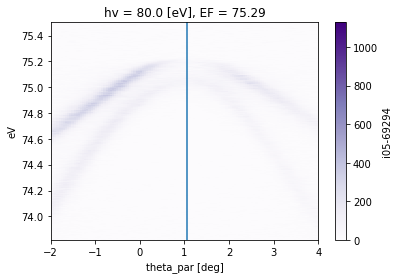

In [115]:
a.plot_hv(80, xlim=[-2,4])
norm_on_plot = 1.05
plt.axvline(norm_on_plot)
print('Normal emission: '+str(a.attrs['tilt']+norm_on_plot))

We can call with similar arguments as above. E.g. to set the EF_curvature correction (`EF_correction=correction`) and normal emission (in this case `norm_tilt=##` as it is Type I). We can also set the inner potential, `V0=##`. Note, it is better to run the auto alignment with the EF_curvature correction already in place otherwise (as in the data above) the EF estimate can be wrong if the intense features are near the edge of the detector. But as EF is now written into the original array by defauly, it will not run the auto-align again. We could do that manually, or we can get rid of the existing automatic estimate using the xarray `drop_vars` command, and then let it run it again when we have declared the EF_correction.

In [116]:
a = a.drop_vars('EF')

Estimating EF:   0%|          | 0/13 [00:00<?, ?it/s]

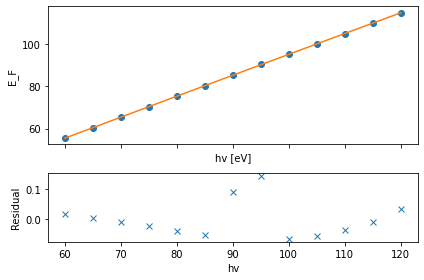

 Analysis warning: Performed automatic Fermi level alignment based on derivative method to find Fermi edge. Check carefully - a more accurate method may be required for proper analysis.
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}


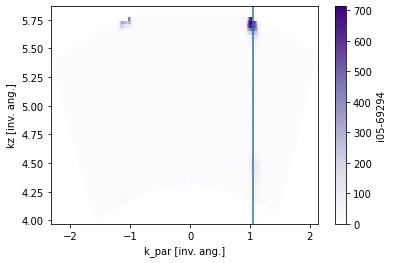

In [117]:
a.proc(EF_correction=correction, norm_tilt=6.05, V0=15, FS=0.02).plot()
plt.axvline(1.05)

For $k_z$-maps, we also have the option to output a single k_par slice or small k_par range with the call `k_par=k0` or `k_par=slice(k0,k1)`. Note, that as above, depending on the configuration k_par can flip sign wrt. the theta_par direction, so be careful which value to choose here...

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}


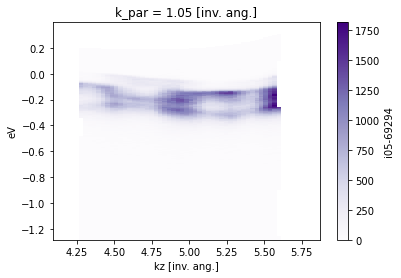

In [118]:
b = a.proc(EF_correction=correction, norm_tilt=6.05, bin_factor=2, V0=15, k_par=1.05)
b.plot(y='eV')

Auto-binning also works here

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}
 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/peaks/process/k_conversion.py:1194: UserWarning:Data array is large, 2x2 binning on energy and theta_par axis has been automatically applied. To run without binning, call function with bin_factor=1.


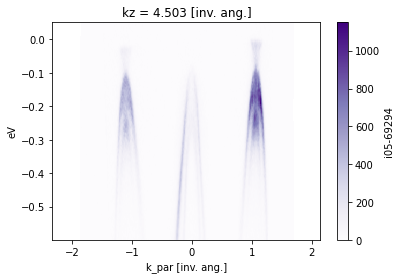

CPU times: user 28.6 s, sys: 4.85 s, total: 33.5 s
Wall time: 31.4 s


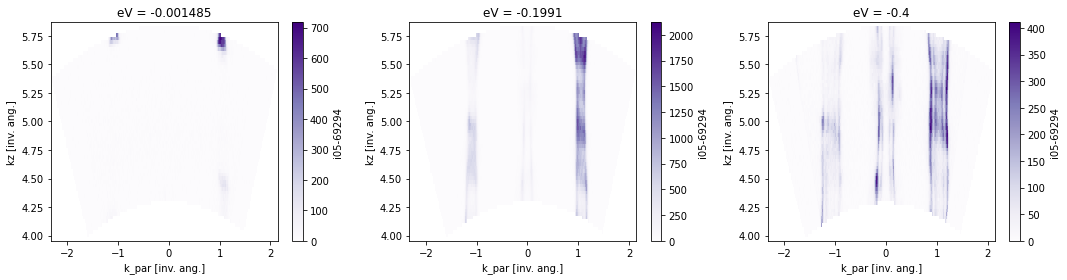

In [120]:
%%time
# Convert a cube
b = a.proc(eV=slice(-0.6,0.05))
b.sel(kz=4.5, method='nearest').T.plot()  # Select a single kz slice from this cube
plt.show()
# Select energy slices from this cube
fig, axes = plt.subplots(ncols=3, figsize=(15,4))
b.sel(eV=0, method='nearest').plot(ax=axes[0])  
b.sel(eV=-0.2, method='nearest').plot(ax=axes[1])
b.sel(eV=-0.4, method='nearest').plot(ax=axes[2])  
plt.tight_layout()

You can ask to convert to binding energy early with the call `convert='BE'`. However, the call to convert just to $k$-space does not work for $k_z$ maps

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}


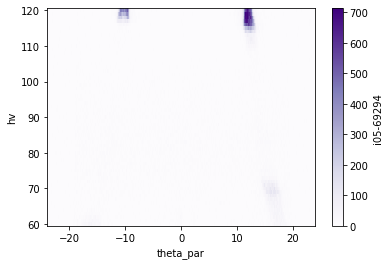

In [121]:
a.proc(convert='BE', FS=0.01).plot()

Even after full conversion, you can still ask to view the data against photon energy not $k_z$ by asking for that in the plot function of the xarray, as long as you have converted a cube of data (it is not able to do this if a Fermi surface has been obtained and thus the data has already been collapsed)

In [122]:
b = a.proc(eV=slice(-0.1,0))

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}


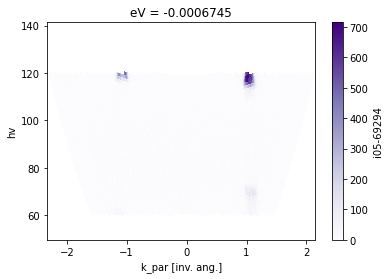

In [123]:
b.sel(eV=0, method='nearest').plot(y='hv')

You can also ask for specific k-point spacings. `k_par` works with `dk=###` as for above. The same works for `dkz=##` where `##` is the k-point spacing you want along the $k_z$ axis. This deafults to the same point density as photon energies.

 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_azi': 20.0}


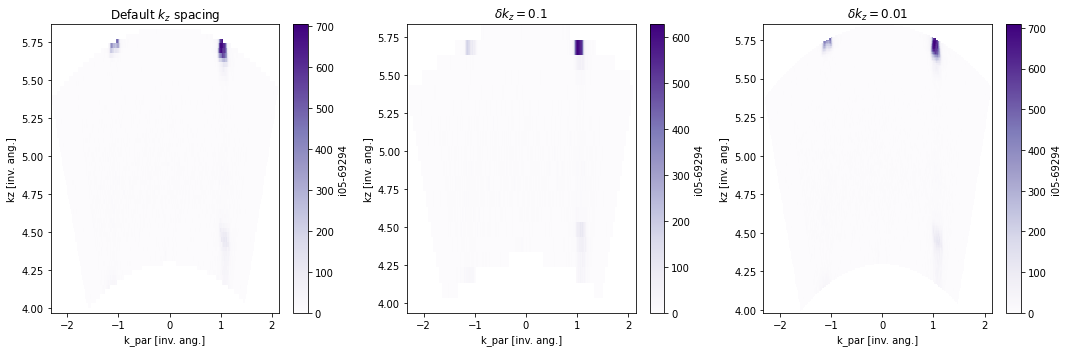

In [124]:
fig, axes = plt.subplots(ncols=3,figsize=(15,5))
b = a.proc(FS=0.01, bin_factor=2).plot(ax=axes[0])
c = a.proc(FS=0.01, bin_factor=2, dkz=0.1).plot(ax=axes[1])
d = a.proc(FS=0.01, bin_factor=2, dkz=0.01).plot(ax=axes[2])
axes[0].set_title(r'Default $k_z$ spacing')
axes[1].set_title(r'$\delta{}k_z=0.1$')
axes[2].set_title(r'$\delta{}k_z=0.01$')
plt.tight_layout()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='batch'></a>
## Batch processing
We can convert multiple dispersions in a 'batch processing' mode by passing a list of xarrays. (These in fact do not need to be the same type of scan, the standard mode of the `proc` function runs for each one seperately). The standard arguments can be passed either as single values (in which case they are applied to each input dataarray), or for the manipulator values and the angular offsets, these can be passed as a list with the same length as the list of dataarrays passed (to apply specific values to each scan)

EDC fitting progress:   0%|          | 0/342 [00:00<?, ?it/s]

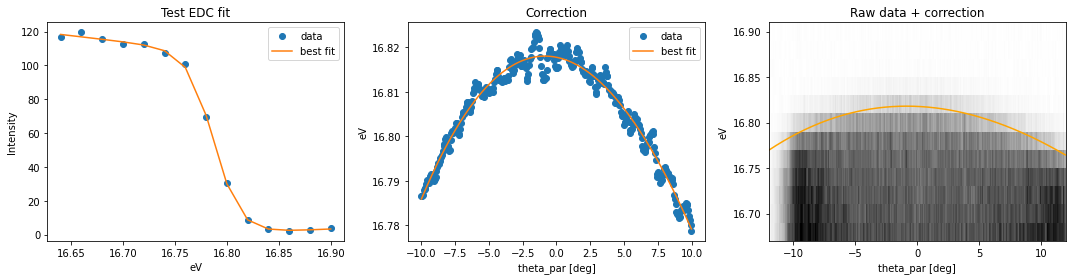

In [17]:
#Load some data
file = "example_data/Gold.xy" #StA ARPES Disp.
gold = load_data(file)
file = "example_data/210326_GM2-667_GK_1.xy" #StA ARPES Disp.
GK_1 = load_data(file)
file = "example_data/210326_GM2-667_GK_2.xy" #StA ARPES Disp.
GK_2 = load_data(file)
file = "example_data/210326_GM2-667_GK_3.xy" #StA ARPES Disp.
GK_3 = load_data(file)
correction = gold.fit_fermi(theta_par=slice(-10,10)) #need to use reduced theta_par range (see disp at below theta_par=-10)

In [127]:
# Pass the scans as a list to the proc function, adding a seperate polar offset for each one
b = proc([GK_1,GK_2,GK_3], polar=[0,12,24], norm_polar = -4, EF_correction=correction)

Batch processing:
210326_GM2-667_GK_1


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


210326_GM2-667_GK_2


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


210326_GM2-667_GK_3


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


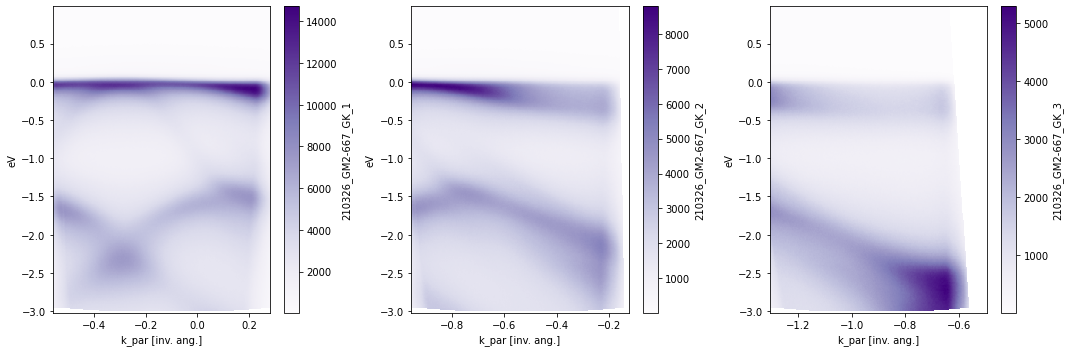

In [129]:
plot_grid(b, y='eV')

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='merge'></a>
## Merging
We can also merge dispersions passed as a list to proc, by calling with the flag `merge=True`. If merging there are two further useful arguments:
 - `flip=True/False` is used to set whether to 'flip' the manipulator axis sign when merging multiple scans onto an enhanced theta_par range. Whether to do this depends on the sign conversion between `theta_par` and the relevant manipulator angle (`polar` or `tilt` depending on Type I or II configuration). This defaults to False, which is correct e.g. for the StA Phibos.
 - `theta_par = slice(th0,th1)` can be used to crop the data to the specified theta_par range before merging the scans together. This is often required in merging as the edges of the detector may be visible, or the scan may show distortions/unphysical intensity variations towards the edges of the detector that need to be cut off to not lead to weird features in the middle of the merged image. 

In [18]:
#Load data again
file = "example_data/Gold.xy" #StA ARPES Disp.
gold = load_data(file)
file = "example_data/210326_GM2-667_GK_1.xy" #StA ARPES Disp.
GK_1 = load_data(file)
file = "example_data/210326_GM2-667_GK_2.xy" #StA ARPES Disp.
GK_2 = load_data(file)
file = "example_data/210326_GM2-667_GK_3.xy" #StA ARPES Disp.
GK_3 = load_data(file)

In [139]:
b = proc([GK_1,GK_2,GK_3], polar=[0,12,24], norm_polar = 4, EF_correction=correction, merge=True, theta_par=slice(-10,10))

Converting to binding energy:
210326_GM2-667_GK_1
210326_GM2-667_GK_2
210326_GM2-667_GK_3
Data cropped to theta_par range : (-10, 10)
Merging data
Converting to k-space


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


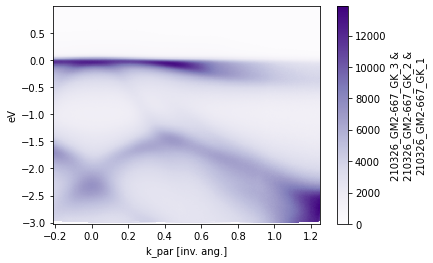

In [140]:
b.plot()

As an example of running with `flip=True`, returns wrong results here, but should be applied in some other cases. 

Converting to binding energy:
210326_GM2-667_GK_1
210326_GM2-667_GK_2
210326_GM2-667_GK_3
Data cropped to theta_par range : (-10, 10)
Merging data
Converting to k-space


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'tilt': 0.0, 'azi': 0.0, 'norm_tilt': 0.0, 'norm_azi': 20.0}


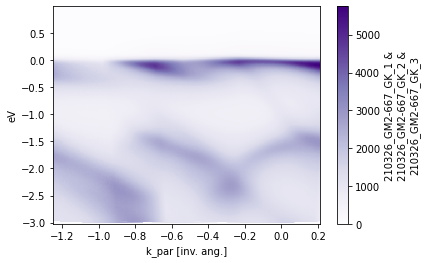

In [142]:
b = proc([GK_1,GK_2,GK_3], polar=[0,12,24], norm_polar = -4, EF_correction=correction, merge=True, flip=True, theta_par=slice(-10,10))
b.plot()

Merging also works for higher-dimensional data.

In [19]:
# Load two Diamond FS maps to join up
file = "example_data/i05-34239.nxs"
map1a = load_data(file)  # Patial range of map 1
file = "example_data/i05-34237.nxs"
map1b = load_data(file)  # Partial range of map 2
file = "example_data/i05-34242.nxs"
map2 = load_data(file)

Persisting data to memory:   0%|          | 0/1 [00:00<?, ?it/s]

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

Persisting data to memory:   0%|          | 0/10 [00:00<?, ?it/s]

In [146]:
# First need to stitch map1a and map1b together, as these are just partial ranges of one slice in this particular example dataset
map1 = xr.concat([map1a,map1b], dim="polar")

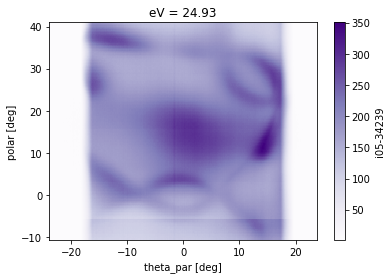

In [147]:
map1.FS(0.01, 25.62).plot()

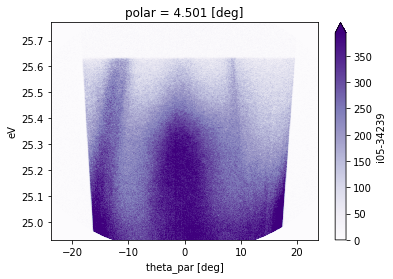

In [149]:
map1.isel(polar=45).plot(robust=True)

Note, these can be slow to convert if calling the full slice, automatic binning is applied if the first dataarray size $>10^8$ points.

In [150]:
b = proc([map1,map2], merge=True, theta_par=slice(-14,14), eV=slice(-0.1,0), flip=True)

 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/peaks/process/process.py:149: UserWarning:Data array is large, 2x2 binning on energy and theta_par axis has been automatically applied. To run without binning, call function with bin_factor=1.


Converting to binding energy:
i05-34239


 Analysis warning: Fermi level set from automatic estimation to 25.632 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.


i05-34242


 Analysis warning: Fermi level set from automatic estimation to 25.632 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.


Data cropped to theta_par range : (-14, 14)
Merging data
Converting to k-space


 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_tilt': 0.0, 'norm_azi': -7.0}


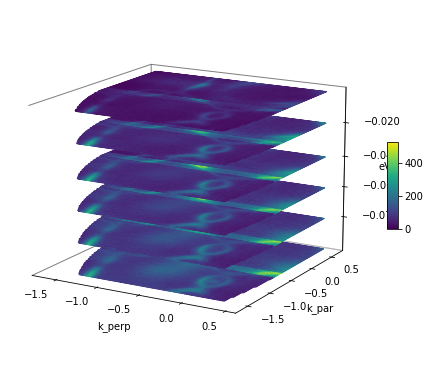

In [151]:
b.FS_stack(-0.1,0,0.025, 0.02, plot=1, cmap='viridis', figsize=(8,8), elev=15)

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='norm'></a>
## Normalisation
Normalise data by a float, EDC/MDC, or region of interest using `.process.norm.norm()`  This is loaded automatically as part of a * import of PyPhoto, and can be called either as `norm(data, *args, **kwargs)` or using the pipe function of xarray, `data.norm(*args, **kwargs)`. Multiple arguments are accepted:

In [152]:
help(norm)

Help on function norm in module peaks.process.norm:

norm(dispersion, *args, **kwargs)
    This function applies a simple normalisation by e.g. an MDC, EDC, or ROI
    
    Input:
        dispersion - the dispersion to be normalised (xarray). If supplied with no further arguments,
          then normalisation to the max value is performed (i.e. spectrum normalised to unity).
          Otherwise specify via:
        *args - optional arguments to normalise by a constant and/or the mean across a complete dimension. E.g.:
            int or float - normalise by that number
            'eV' - normalise by an integrated MDC
            'theta_par' or 'k_par' or 'k_perp' - normalise by an integrated EDC in that direction
            'all' - normalise by mean of the xarray
        **kwargs - optional arguments to define the slice to normalise by. E.g.:
            eV=slice(105,105.1)) -- normalized by an integrated MDC defined by the eV slice given, automatically
              broadcast over a

### Example on a dispersion

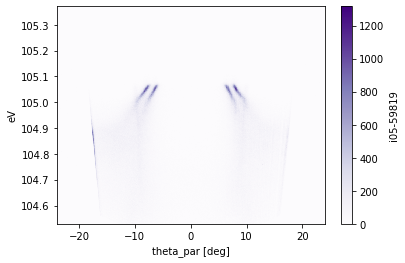

In [154]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV')

### Normalising by max value

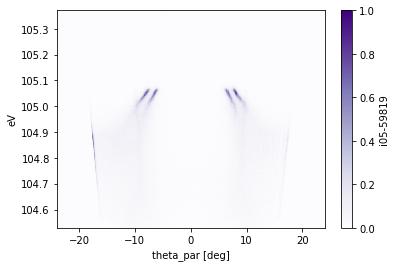

In [155]:
a.norm().plot(y='eV')

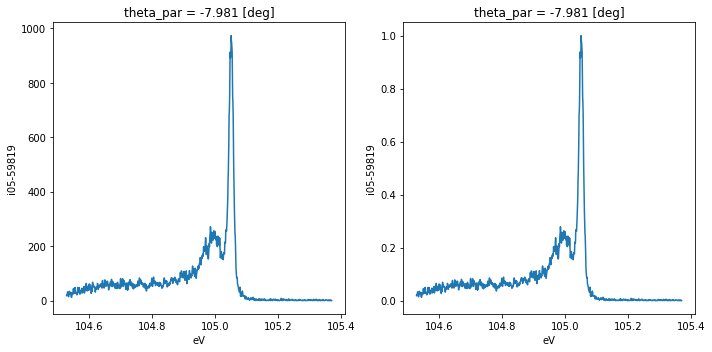

In [156]:
plot_grid([a.EDC(-8),a.EDC(-8).norm()])

### Normalising by a single number

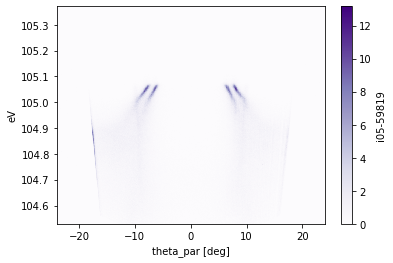

In [157]:
#normalise entire array by 100
a.norm(100).plot(y='eV')

We can normlise by the mean of the array with the shortcut 'all'

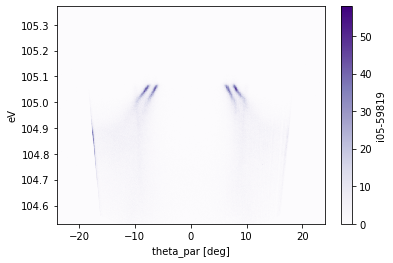

In [158]:
a.norm('all').plot(y='eV')

In [159]:
#The above has normalised by mean of dataarray:
a.mean().values

array(22.74448, dtype=float32)

We can normalise by these both, or in fact any number or combination

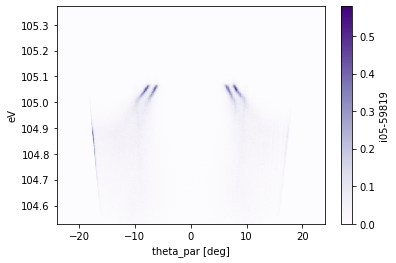

In [160]:
a.norm(10,10,'all').plot(y='eV')

### Normalising by an EDC or MDC
There is a shortcut to divide by an integrated MDC or EDC across the entire array, by calling the coordinate name as a string.

E.g. the integrated EDC of this array:

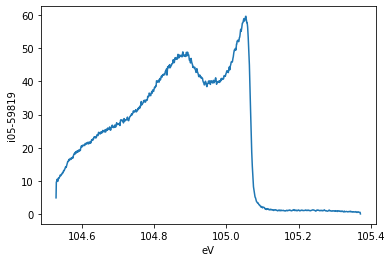

In [161]:
a.mean('theta_par').plot()

Normalising our 2D array by the above integrated EDC will divide each MDC by the equivalent value at that energy in this EDC, or the equivalent for the integrated MDC

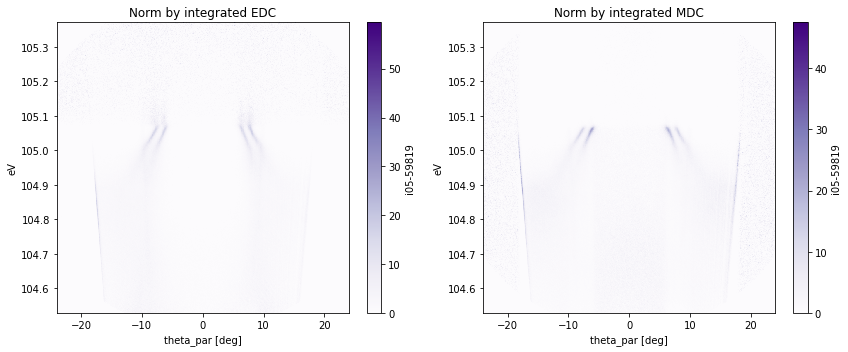

In [162]:
fig, axes = plt.subplots(ncols=2, figsize=(12,5))
a.norm('theta_par').plot(y='eV', ax=axes[0])
axes[0].set_title('Norm by integrated EDC')
a.norm('eV').plot(y='eV', ax=axes[1])
axes[1].set_title('Norm by integrated MDC')
plt.tight_layout()

We can also integrate over a relevant DC defined over some integration region by calling with a slice command

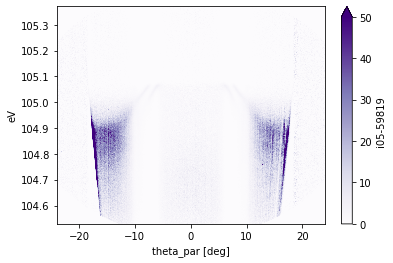

In [163]:
a.norm(eV=slice(105,105.1)).plot(y='eV', vmax=50)

### Region of interest

If we call e.g. both an EDC and MDC region to normalise a 2D array, this defines a region of interest, and we normalise by the mean value within that ROI 

In [164]:
#Mean of the following ROI
a.sel(eV=slice(104.9,105),theta_par=slice(-15,-10)).mean().values

array(77.7265, dtype=float32)

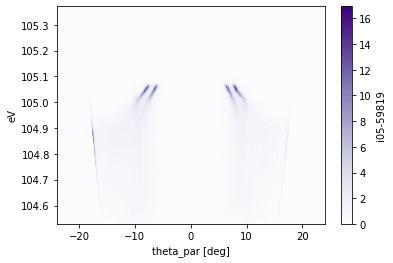

In [165]:
#Normalise by this ROI mean
a.norm(eV=slice(104.9,105),theta_par=slice(-15,-10)).plot(y='eV')

We can mix integrated and defined regions, and can combine with normalisation by a single number. 

NB the order of args (numbers and strings) and kwargs (labelled slices) matters here.

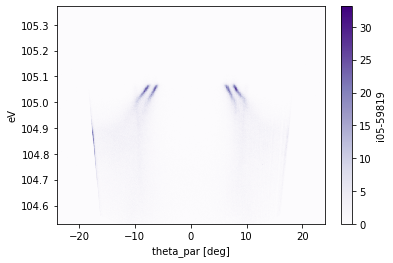

In [166]:
a.norm('eV', theta_par=slice(-15,-10)).plot(y='eV')

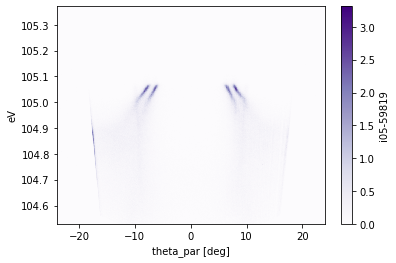

In [167]:
a.norm(10, 'eV', theta_par=slice(-15,-10)).plot(y='eV')

If we take a 1D array, then a single slice along that region corresponds to an effective ROI

E.g. for an EDC

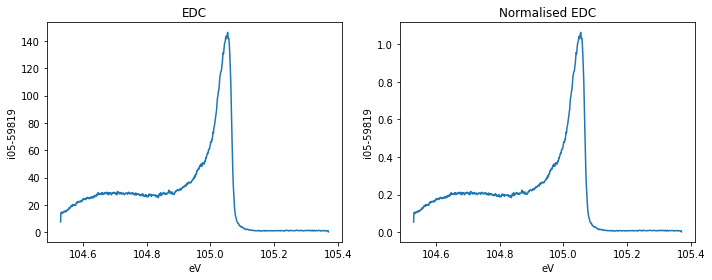

In [168]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
b = a.sel(theta_par=slice(-9.5,9)).mean('theta_par')
b.plot(ax=axes[0])
axes[0].set_title('EDC')
b.norm(eV=slice(105.04,105.05)).plot(ax=axes[1])
axes[1].set_title('Normalised EDC')
plt.tight_layout()

This should all broadcast OK for higher-dimension arrays as well, although that is not tested much yet. 

### Normalisation using user-defined wave
We can feed directly the normalisation wave as an xarray with the values and a co-ordinate which matches that of the data to be normalised.

E.g. normalising by an EDC manually extracted from the original data:

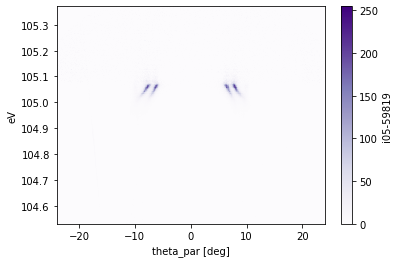

In [169]:
#Define the normalisation wave
norm_wave = a.sel(theta_par=slice(-15,-10)).mean('theta_par')
norm_wave
a.norm(norm_wave).plot(y='eV')

We can also call this with a normalisation wave defined on the same axis range using an xarray, but which does not match all co-ordinate values, or even cover the same range. E.g. let's define a linear background.

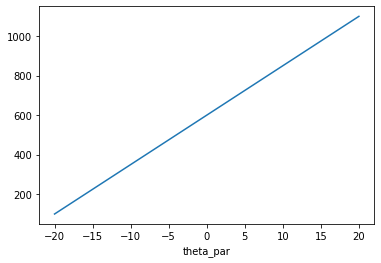

In [170]:
#Make a dummy background wave
data = np.arange(11)*100+100
theta_par = (np.arange(11)*4)-20

bgw = xr.DataArray(data, coords=[theta_par], dims=["theta_par"])
bgw.plot()

Use this to normalise - it will be extrapolated over the full range and interpolated to match the data points. We will get a warning that interpolation was utilised, but it will still run. 

 Analysis warning: Coordinates of normalisation wave do not match those in data. Interpolating for normalisation.


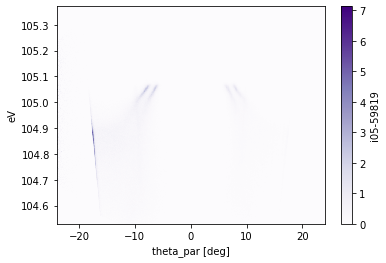

In [171]:
a.norm(bgw).plot(y='eV')

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='bgs'></a>
## Background subtraction

Background subtraction works in exactly the same way, except calling bgs, and the relevant parameters passed definie the wave to subtract. 

In [172]:
help(bgs)

Help on function bgs in module peaks.process.norm:

bgs(dispersion, *args, **kwargs)
    This function applies a simple background subtraction by e.g. an MDC, EDC, or ROI. It works just by calling
    the norm function with a flag to indicate background subtraction
    
    Input:
    
        `dispersion` - the dispersion to be normalised (xarray)
    
        `*args` - optional arguments to normalise by a constant and/or the mean across a complete dimension. E.g.:
    
            - `int` or `float` - subtract that number
    
            - ``eV'` - subtract an integrated MDC
    
            - `'theta_par'` or `'k_par'` or `'k_perp'` - subtract an integrated EDC in that direction
    
            - `'Shirley'` - subtract a shirley background, assuming default parameters unless `shirley_options`
                also passed. NB if Shirley passed, all other arguments ignored and only a Shirley bgs performed
    
            - `'all'` - subtract the mean of the xarray
    
        `**kw

For example, background subtraction of an MDC:

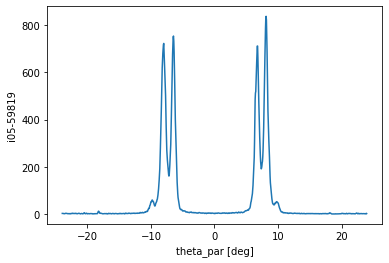

In [173]:
#MDC to subtract (bad example but shows the operation)
a.sel(eV=slice(105.04,105.06)).mean('eV').plot()

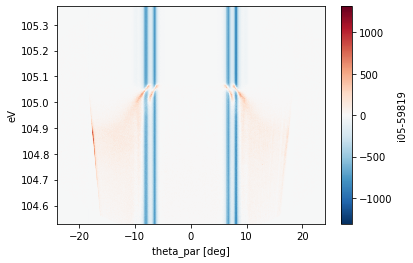

In [174]:
a.bgs(eV=slice(105.04,105.06)).plot(y='eV')

We have the full options from the normalisation methods, including feeding it a particular background wave as an xarray. E.g., let's use our linear background from before. 

 Analysis warning: Coordinates of normalisation wave do not match those in data. Interpolating for normalisation.


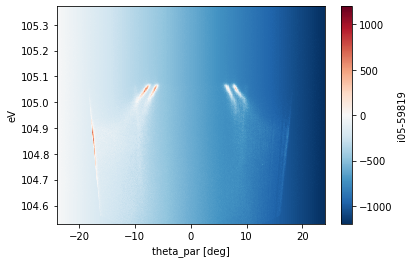

In [175]:
a.bgs(bgw).plot(y='eV')

There is also an option to subtract a Shirley background by calling with `Shirley`. The background is calculated over the full range passed. The options for averaging and left and right offsets can be passed as a dictionary of `Shirley_opts`. See `.fit.User_Fit_function.Shirley()` for more information on the background subtraction.

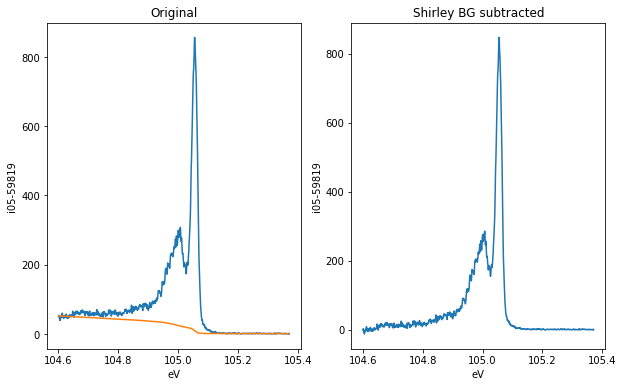

In [177]:
# Import the function now just so we can explicitly show the background here 
# (this is not required simply to do the BG subtraction)
from peaks.fit.User_Fit_function import Shirley
EDC1 = a.EDC(8, 0.5).sel(eV=slice(104.6,None))
Shirley_bg = Shirley(EDC1.data, average=3)

# This is how to do the simple Shirley BGS
EDC1_bgs = EDC1.bgs('Shirley', Shirley_opts={'average': 3})

# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(10,6))
EDC1.plot(ax=ax[0])
ax[0].plot(EDC1.eV.data, Shirley_bg)
EDC1_bgs.plot(ax=ax[1])
ax[0].set_title('Original')
ax[1].set_title('Shirley BG subtracted')
plt.show()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='binning'></a>
## Data binning

### Binning using .coarsen
Binning can be performed using the built-in `xarray.coarsen` function. Use `keep_attrs=True` to retain the original attributes of the array.
### Example on a dispersion

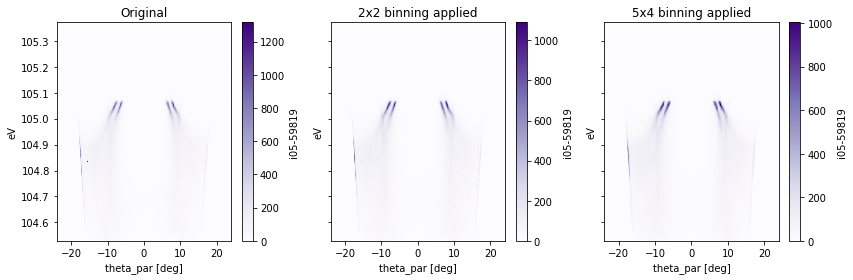

In [180]:
fig, axes = plt.subplots(ncols=3, figsize=(12,4), sharey=True)
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV', ax=axes[0])
axes[0].set_title('Original')
#2x2 binning
b=a.coarsen(eV=2,theta_par=2).mean()
b.plot(y='eV', ax=axes[1])
axes[1].set_title('2x2 binning applied')
#5x4 binning
c=a.coarsen(eV=4,theta_par=5).mean()
c.plot(y='eV', ax=axes[2])
axes[2].set_title('5x4 binning applied')
plt.tight_layout()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='Smoothing'></a>
## Smoothing

Smoothing of data can be applied using `.process.smooth.smooth`:

In [181]:
help(smooth)

Help on function smooth in module peaks.process.smooth:

smooth(data, **kwargs)
    Smooth data contained in an xarray dataarray as per the specified parameters, and return the smoothed
    array. Uses scipy gaussian_filter function.
    
    Input:
        data - the data to smooth (xarray)
        **kwargs - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian
          for convolution in this direction (coord=ax)
    
    Returns:
        smoothed_data - the smoothed data (xarray)
        
    Example:
        smooth(dispersion, theta_par=0.5, eV=0.2) to smooth dispersion by a Gaussian with FWHM 0.5 deg and 0.2 eV



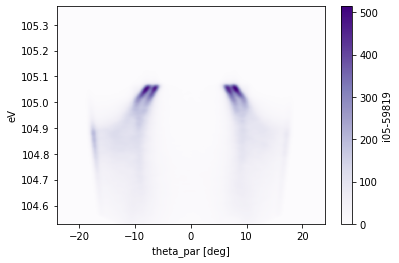

In [185]:
b = a.smooth(eV=0.01,theta_par=1)
b.plot(y='eV')

#### 3D example
Smoothing function can be applied to higher dimensional data, and will smooth (Gaussian convolution) over the axes specified. This now gets a bit slow for higher-D data...

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Smoothed also in energy direction')

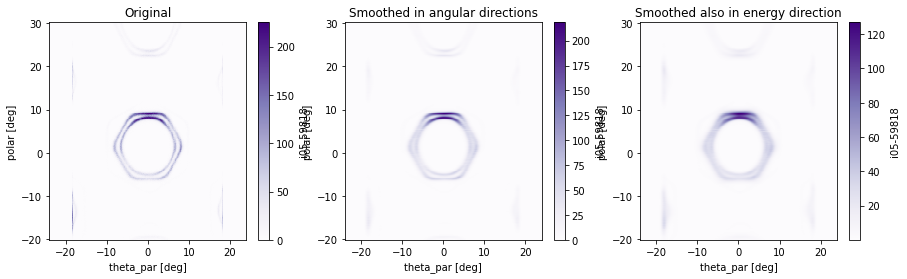

In [20]:
# Load data (FS map)
a = load_data('example_data/i05-59818.nxs')
fig, axes = plt.subplots(ncols=3,figsize=(15,4))
a.sel(eV=slice(105.04,105.06)).mean('eV').plot(ax=axes[0])
axes[0].set_title('Original')
a.smooth(polar=0.1,theta_par=1).pipe(FS,105.05,0.02).plot(ax=axes[1])
axes[1].set_title('Smoothed in angular directions')
a.smooth(polar=0.1,theta_par=1, eV=0.05).pipe(FS,105.05,0.02).plot(ax=axes[2])
axes[2].set_title('Smoothed also in energy direction')

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='deriv'></a>
## Derivative-type methods

`xarray` has an in-built derivative function, `.differentiate('dim')`:

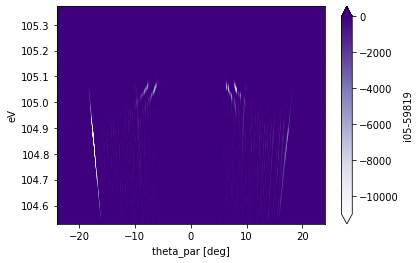

In [21]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
b = a.smooth(eV=0.02,theta_par=0.2).differentiate('theta_par').differentiate('theta_par')
b.plot(y='eV', vmin=0, vmax=-10000)

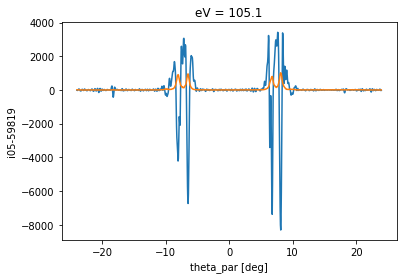

In [191]:
b.MDC(105.05).plot()
a.MDC(105.05).plot()

### Shortcut functions for taking useful derivatives for ARPES in `.process.deriv`
For second derivative of a dispersion in energy, call as `d2E(dispersion, <i>plot</i>, <i>kwargs</i>)` or `.pipe(d2E, dispersion, <i>plot</i>, <i>kwargs</i>)`:

In [192]:
help(d2E)

Help on function d2E in module peaks.process.deriv:

d2E(dispersion, plot=False, **kwargs)
    Perform double differential in the energy direction of data contained in an xarray dataarray, with
     smoothing applied as per the specified parameters.
    
    Input:
        dispersion - the data to differentiate (xarray)
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        diff_data - the smoothed and differentiated data (xarray)
        
    Example:
        d2E(dispersion, theta_par=0.5, eV=0.2) to smooth dispersion by a Gaussian with FWHM 0.5 deg and 0.2 eV and perform d2/d(E)^2



Equivalent versions exist for taking derivatives in the momentum (or angular) direction, `d2k(...)`, and for taking a combined derivative $d^2/dEdk$, `dEdk(...)`. The arguments are the same as above.

E.g. to take a second derivative in energy of an array with some smoothing in the two axes (FWHM 20 meV in eneergy, 0.2 deg in angle):

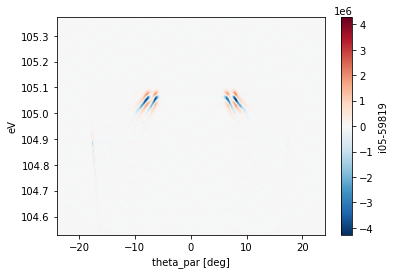

In [193]:
b = a.d2E(eV=0.02,theta_par=0.2)
b.plot(y='eV')

We can get this to return directly a plot with some attempt at a choice of sensible colour scale

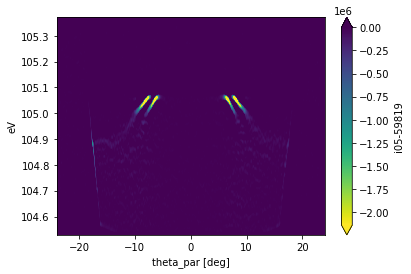

In [194]:
a.d2E(eV=0.02,theta_par=0.2, plot=1)

You can also supply standard matplotlib calls to further spec the plot

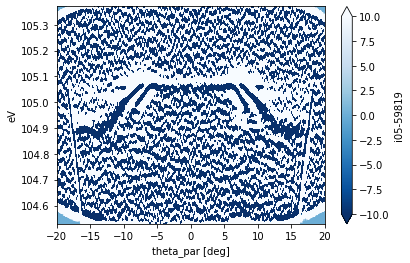

In [195]:
a.d2E(eV=0.02,theta_par=0.2, plot=1, xlim=[-20,20], vmin=-10, vmax=10, cmap='Blues_r')

Equivalent call for double derivative in the momentum direction. This in fact works on whatever is the non-energy direction of a 2D xarray, so can be used irrespective of e.g. `theta_par`, `k_par` etc. on angular axis:

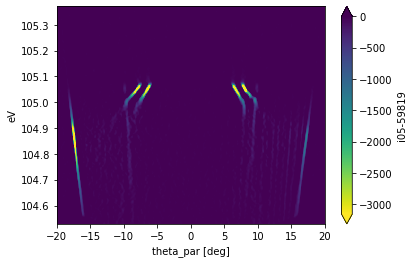

In [196]:
a.d2k(eV=0.01,theta_par=0.5, plot=1, xlim=[-20,20])

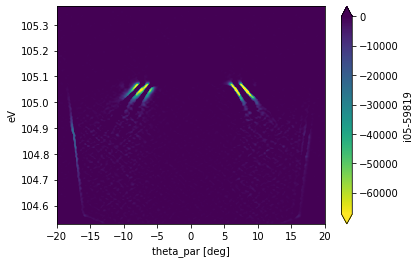

In [197]:
dEdk(a,eV=0.01,theta_par=0.5, plot=1, xlim=[-20,20])

### Second derivatives along any arbitrary axes in `.process.deriv`
Second derivatives can be taken along any combination of 2 axes. Call as `double_diff(data, dim1, dim2, <i>plot</i>, <i>kwargs</i>)` or `data.double_diff(coord1, coord2, <i>plot</i>, <i>kwargs</i>)` (this is in fact the master function for taking the derivatives called in all of the above shortcut versions):

In [198]:
help(double_diff)

Help on function double_diff in module peaks.process.deriv:

double_diff(data, dim1, dim2, plot=False, **kwargs)
    Perform double differential along the specified dimensions of data contained in an xarray dataarray
    
    Input:
        data - the data to differentiate (xarray)
        dim1 - dimension for first derivative
        dim2 - dimension for second derivative
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        diff_data - differentiated data (xarray)
        
    Example:
        double_diff(dispersion, 'eV', 'eV') to perform d2/d(eV)^2



E.g. to take a second derivative in energy:

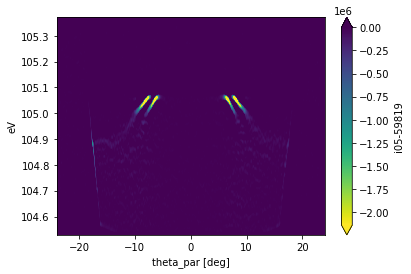

In [199]:
a.double_diff('eV','eV', eV=0.02,theta_par=0.2, plot=1)

<a id='curv'></a>
## Curvature analysis in `.process.deriv`
### 2D Curvature

In [200]:
help(curvature)

Help on function curvature in module peaks.process.deriv:

curvature(data, C0, C1, plot=False, **kwargs)
    Perform 2D curvature analysis (see Rev. Sci. Instrum.  82, 043712 (2011)) to data contained in an xarray
       dataarray
    
    Input:
        data - the data to differentiate (xarray)
        C0 - free parameter for axis 0
        C1 - free parameter for axis 1
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        curve_data - curvature data (xarray)
        
    Example:
        curvature(dispersion, 10, 1, plot=1, theta_par=0.3, eV=0.01) to perform curvature with some smoothing



C0 scaling for eV, C1 scaling for theta_par


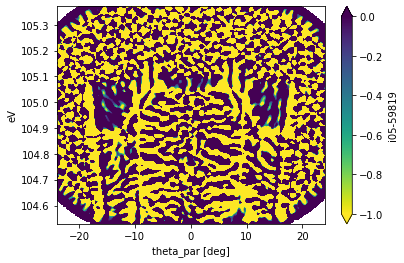

In [201]:
a.curvature(100,1000, plot=1, eV=0.02,theta_par=1,)

### 1D curvature

In [202]:
help(curv1d)

Help on function curv1d in module peaks.process.deriv:

curv1d(data, dim, C0, plot=False, **kwargs)
    Perform 1D curvature analysis (see Rev. Sci. Instrum.  82, 043712 (2011)) to data contained in an xarray
      dataarray
    
    Input:
        data - the data to differentiate (xarray)
        dim - name of the dimension to apply the curvature along
        C0 - free parameter
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        curve_data - curvature data (xarray)
        
    Example:
        curvature(dispersion, 10, 1, plot=1, theta_par=0.3, eV=0.01) to perform curvature with some smoothing



E.g. taking the 1d curvature along the 'eV' axis. If running with a very high C0 value, equilvaent to a standard second derivative plot. 

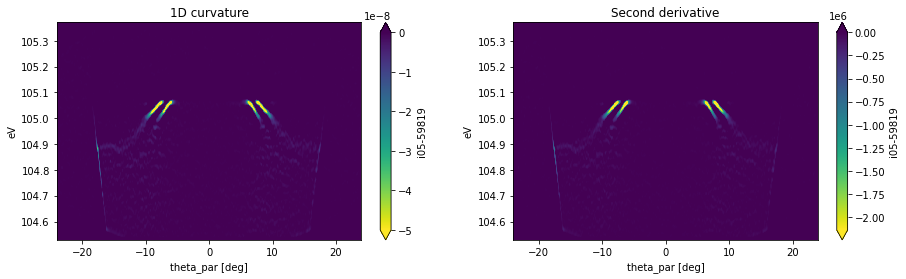

In [203]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 4))
#Curvature
a.curv1d('eV',1000000000, eV=0.02,theta_par=0.2, plot=1, vmin=-0.00000005, ax = axes[0])
axes[0].set_title('1D curvature');
#2nd derivative
a.d2E(eV=0.02,theta_par=0.2, plot=1, ax=axes[1])
axes[1].set_title('Second derivative');



But e.g. with a smaller C0:

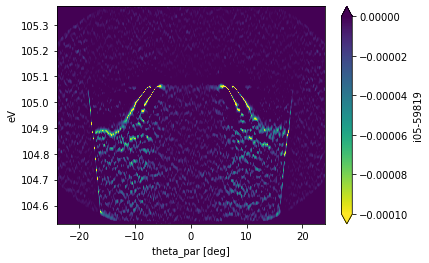

In [204]:
a.curv1d('eV',1000000, eV=0.02,theta_par=0.2, plot=1, vmin=-0.0001)

<a id='min_grad'></a>
## Minimum gradient method in `.process.deriv`
Applies minimum gradient analysis, using Gaussian filtering. Method based on Rev. Sci. Instrum 88 (2017) 073903, and uses the `scipy.ndimage.gaussian_gradient_magnitude` function. Call as `min_grad(a, <i>plot</i>, <i>kwargs</i>)` or `a.min_grad(<i>plot</i>, <i>kwargs</i>)`:

In [205]:
help(min_grad)

Help on function min_grad in module peaks.process.deriv:

min_grad(data, plot=False, **kwargs)
    Apply minimum gradient analysis, using Gaussian filtering. Method based on Rev. Sci. Instrum 88 (2017)
      073903, and uses the scipy.ndimage.gaussian_gradient_magnitude function.
    
    Input:
        data - the data to apply gradient magnetiude analysis to (xarray)
        plot (optional) - set to True to return a plot rather than an xarray
        **kwargs - optional arguments:
            - axes to smooth over in the format ax=FWHM, where FWHM is the relevant FWHM of the Gaussian for
              convolution in this direction (coord=ax)
            - can also supply optional parameters to pass to plotting function here (standard MatPlotLib calls)
    
    Returns:
        grad_mod - renormalised gradient modulus map (xarray)
        
    Example:
        min_grad(dispersion, theta_par=0.5, eV=0.2).



 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide
 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide
 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide


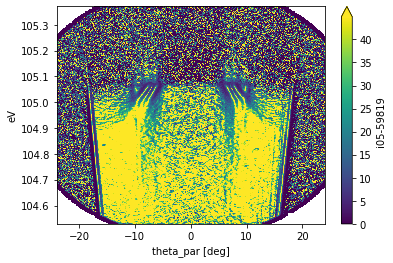

In [206]:
a.min_grad(plot=True, theta_par=0.5,eV=0.005)

 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide


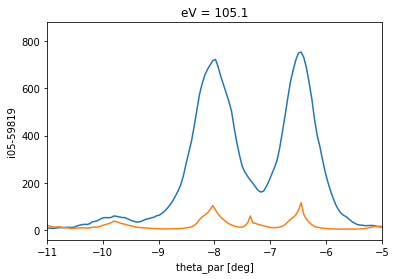

In [208]:
a.MDC(105.05, 0.02).plot(xlim=[-11,-5])
b = min_grad(a, plot=0, theta_par=0.5,eV=0.02)
b.MDC(105.05, 0.02).plot()

<div style="text-align: right"> <a href='#top'>Go back to top</a> </div>

<a id='symm'></a>
## Symmetrisation functions in `.process.symm`

### $E_f$ symmetrisation
`.process.symm.EF_sym` function to symmetrise an array in energy, useful e.g. for symmetrising about the Fermi level for gap analysis etc. 

Call as `EF_sym(a, En)` or `a.EF_sym(En)` where `a` is the relevant xarray dataarray to symmetrise and `En` is the energy to symmetrise about. `En` can be omitted, in which case set to default `En=0`:

In [209]:
help(EF_sym)

Help on function EF_sym in module peaks.process.symm:

EF_sym(dispersion, En=0.0)
    This function applies a symmetrisation around a given energy
    
    Input:
        dispersion - the dispersion to be symmetrised (xarray)
        En - float; energy for symmetrising about. Default is 0.0 eV (suitable for symmetrising around E_F if
          data is in binding energy)
    
    Returns:
        sym_dispersion - the symmetrised dispersion (xarray)



E.g., acting on single dispersion:

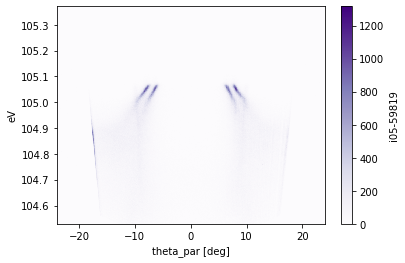

In [25]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV')

Symmetrise about the energy 105.06 eV

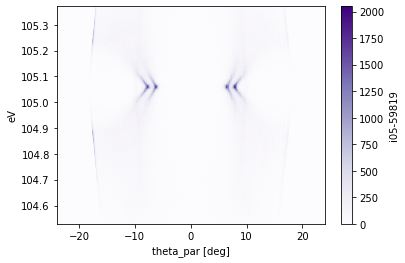

In [26]:
a.EF_sym(105.06).plot(y='eV')

Consider e.g. if we have already done E_F correction:

 Analysis warning: Fermi level set from automatic estimation to 105.068 eV. NB may not be very accurate; check this carefully. To set specific correction, write suitable 'EF_correction' attribute to data, or call this function with argument 'EF_correction = ##' where ## is a suitable correction.
 Analysis warning: Some manipulator and/or normal emission values missing. These have been set to default values: {'norm_polar': 0.0, 'norm_tilt': 0.0, 'norm_azi': -12.5}


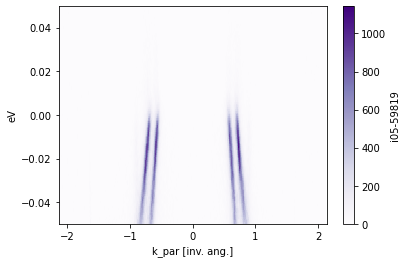

In [213]:
b = a.proc()
b.sel(eV=slice(-0.05,0.05)).plot(y='eV')

Now we can apply directly the E_F symmetrisation function to this without giving an energy arguemnt, in which case the Fermi energy is assumed for the symmetrisation:

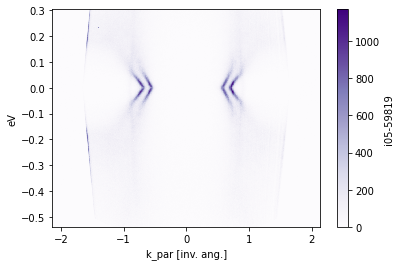

In [214]:
b.EF_sym().plot(y='eV')

#### Applying to higher-D arrays
This broadcasts across higher-dimensional arrays. E.g. for a Fermi surface map:

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

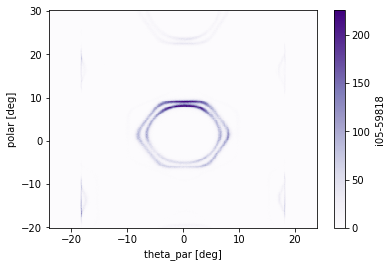

In [216]:
# Load data (FS map)
a = load_data('example_data/i05-59818.nxs')
a.sel(eV=slice(105.04,105.06)).mean('eV').plot()

Take a slice at 105.1 eV:

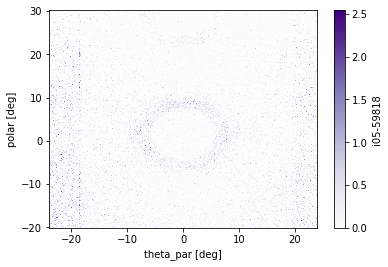

In [217]:
a.sel(eV=slice(105.1,105.11)).mean('eV').plot()

Symmetrise the data about the Fermi level (this takes a bit longer now)

In [220]:
b= a.EF_sym(105.067)

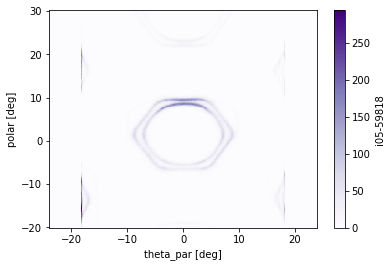

In [221]:
b.sel(eV=slice(105.1,105.11)).mean('eV').plot()

### `sym1d` function in `.process.symm`
Function to symmetrise an array around any 1D axis.

In [222]:
help(sym1d)

Help on function sym1d in module peaks.process.symm:

sym1d(dispersion, **kwargs)
    This function applies a symmetrisation around a given single axis
    
    Input:
        dispersion - the dispersion to be symmetrised (xarray)
        **kwarg optional arguments
            - ax = value, where ax is the name of the relevant xarray coordinate and value is the
              value for symmetrising about.
            - return_flipped = True, to return the flipped dispersion rather than the sum of the
              original and flipped
    
    Returns:
        sym_dispersion - the symmetrised dispersion (xarray)



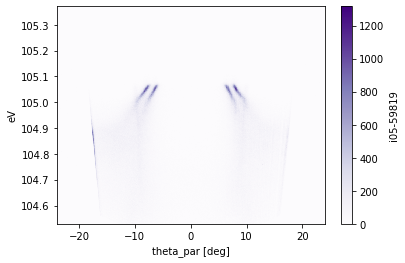

In [224]:
# Load data (single dispersion)
a = load_data('example_data/i05-59819.nxs')
a.plot(y='eV')

Example of symmetrising this array about theta_par = -6 as an illustrative example.

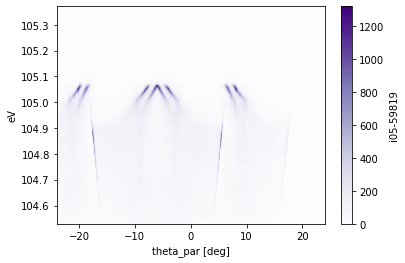

In [225]:
a.sym1d(theta_par=-6).plot(y='eV')

### `rotation` function in `.process.rotation`
Function to rotate an xarray

In [226]:
help(rotation)

Help on function rotation in module peaks.process.rotation:

rotation(xarray, rotation)
    This function takes a 2D input xarray and rotates it around (0,0)
    
    Inputs:
        xarray - the data which will be rotated (xarray)
        rotation - the rotation in degrees which will be applied (float/int)
    
    Returns:
        rotated_xarray - the rotated xarray



In [228]:
# Load data (FS map)
a = load_data('example_data/i05-59818.nxs')

Persisting data to memory:   0%|          | 0/8 [00:00<?, ?it/s]

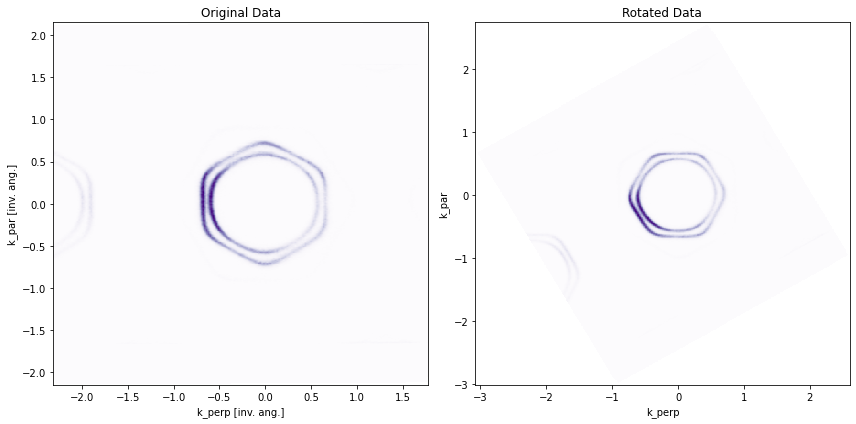

In [229]:
data = a.proc(FS=0.01, norm_polar = 1.4, norm_tilt = 0, norm_azi = a.attrs['azi'] + 0.3, EF_correction = 105.06)
rotated_data = data.rotation(30)

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
data.plot(ax=axes[0],add_colorbar=False)
axes[0].set_title("Original Data")
rotated_data.plot(ax=axes[1],add_colorbar=False)
axes[1].set_title("Rotated Data")
plt.tight_layout()

### `rot_sym` function in `.process.symm`
Function to symmetrise an array by considering its rotation Symmetry

In [230]:
help(rot_sym)

Help on function rot_sym in module peaks.process.symm:

rot_sym(xarray, order, expand=True, fillna=True)
    This function takes a 2D input xarray and symmetrises it around a centre coordinate, by a goiven rotation order
    
    Inputs:
        xarray - the data which will be symmetrised (xarray)
        order - rotation order (int)
        **kwargs
            expand - whether or not to expand the coord grid
            fillna - whether or not to plot data where some rotated xarrays have nans
            
    Returns:
        symmetrised_xarray - the symmetrised xarray



 /Users/pdk6/Dropbox/Work/Lab/Software/PyPhoto/PyPhoto_Master/venv_office/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning:invalid value encountered in true_divide


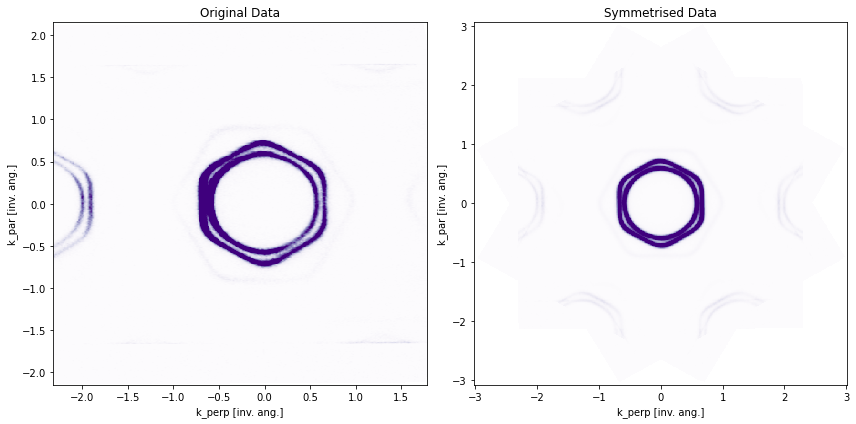

In [286]:
rot_sym_data = data.rot_sym(6)

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
data.plot(ax=axes[0],add_colorbar=False,vmin=0,vmax=50)
axes[0].set_title("Original Data")
rot_sym_data.plot(ax=axes[1],add_colorbar=False,vmin=0,vmax=50)
axes[1].set_title("Symmetrised Data")
plt.tight_layout()